In [1]:
from config import *
from dataset import bandpass_filter, highpass_filter, process_sample, process_segment
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from ipywidgets import interact, interactive, fixed, interact_manual
from keras.models import load_model
import matplotlib
import scipy
%matplotlib inline

In [2]:
# df = pd.read_csv('../ECG_Data/WA20_pre1001.txt', header=None, usecols=[1, 3])
df = pd.read_csv(os.path.join('..', 'Training', f'{animal}_val.txt'), header=None, sep=' ')
df[0] = pd.to_numeric(df[0], errors ='coerce').fillna(0)

In [3]:
df = pd.read_csv('../ECG_Data/WA20_pre1.ascii', header=None, usecols=[1], skiprows=8)
ecg = pd.to_numeric(df[1], errors ='coerce').fillna(0).to_numpy()

C:\Users\tonyz\AppData\Local\Temp\ipykernel_63972\3409181777.py:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../ECG_Data/WA20_pre1.ascii', header=None, usecols=[1], skiprows=8)


In [3]:
ecg = np.array(df[0])
signal = np.array(df[1])
clean_ecg = highpass_filter(ecg, 1, 5, nyq)
bandpass_ecg = bandpass_filter(ecg, 1, 5, high_cutoff, nyq)
deriv_ecg = np.gradient(bandpass_ecg)
squared_ecg = np.power(deriv_ecg, 2)
moving_avg_ecg = np.convolve(squared_ecg, np.ones(40), mode='same')

In [4]:
model = load_model(f'{animal}_model_val_auc')

In [7]:
def data_generator(X, y, batch_size=128, steps_per_epoch=500, invert=True):
    shuffle = True
    X_normal = process_segment(X)
    if invert:
        X_inverted = process_segment(-X)
    while True:
        if shuffle:
            shuffle = False  # This loop is used to run the generator indefinitely.
            random_inds = np.random.randint(0, len(X) - stack * window_size, batch_size * steps_per_epoch * 2)
            random_inds = random_inds.reshape(steps_per_epoch, batch_size * 2)
        else:
            for inds in random_inds:
                data = []
                labels = []
                for ind in inds:
                    y_i = y[ind:ind + int(stack * window_size)]
                    count = np.count_nonzero(y_i)
                    if count < 6:
                        continue
                    # y_i = np.array(y_i).reshape((stack * window_size // 4, 4))
                    # y_i = np.max(y_i, axis=-1)

                    if np.random.random() < 0.5 or not invert:
                        x_i = X_normal[ind:ind + int(stack * window_size)]
                        x_i = process_sample(x_i)
                    else:
                        x_i = X_inverted[ind:ind + int(stack * window_size)]
                        x_i = process_sample(x_i)

                    data.append(x_i)
                    labels.append(y_i)

                data = np.stack(data)
                labels = np.stack(labels)
                # labels = np.concatenate((labels, 1 - np.max(labels, axis=-1)[:, :, np.newaxis]), axis=-1)
                # labels = np.argmax(labels, axis=-1)

                # diff = np.max(data, axis=1) - np.min(data, axis=1)
                # data = data / diff[:, np.newaxis, :]
                yield data, labels
            shuffle = True

In [5]:
segments = process_segment(ecg)
# generator = data_generator(ecg, signal, invert=False)
samples = []

In [6]:
for i in range(len(ecg) // (window_size * stack)):
    samples.append(process_sample(segments[i * window_size * stack: (i + 1) * window_size * stack]))

In [7]:
samples = np.array(samples)

In [8]:
predictions = model.predict(samples)

2700/2700 [==============================] - 48s 16ms/step


In [9]:
del samples, segments

In [16]:
markings = scipy.special.expit(predictions) > 0.5
markings[1:][markings[:-1]==markings[1:]] = 0
signal_inds = np.flatnonzero(markings)

In [19]:
processed_sig_final = [0] * len(ecg)
curr_ind = None
curr_interval = None
for i, ind in enumerate(signal_inds):
    if curr_ind is None:
        curr_ind = ind
        processed_sig_final[ind] = 1
        continue
    interval = ind - curr_ind
    if curr_interval is None:
        upper_thresh = 1.3
        lower_thresh = 0.7
    else:
        upper_thresh = 1.16
        lower_thresh = 0.8
    if upper_thresh * interval_length > interval:
        curr_ind = None
        curr_interval = None
        # prev_interval = None
    if interval > lower_thresh * interval_length:
        curr_interval = interval
        curr_ind = ind
        processed_sig_final[ind] = 1

In [21]:
len(np.flatnonzero(processed_sig_final))

403611

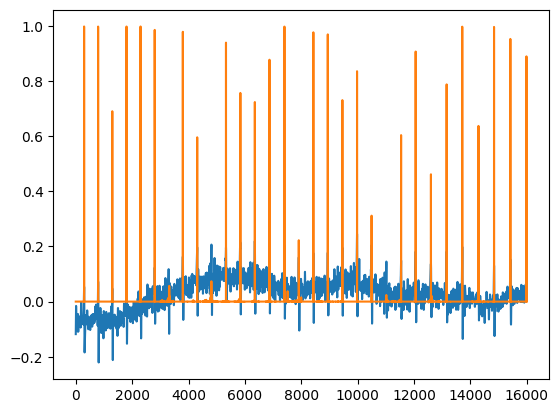

In [15]:
plt.plot(ecg[:16000])
plt.plot(scipy.special.expit(predictions.flatten()[:16000]))
plt.show()

In [24]:
final_predictions = predictions.flatten()

In [25]:
import keras

In [26]:
keras.metrics.Recall(thresholds=0)(signal, final_predictions)

<tf.Tensor: shape=(), dtype=float32, numpy=0.9779844>

In [14]:
x_sample, y_sample = next(generator)

In [15]:
y_pred = model.predict(x_sample)

8/8 [==============================] - 1s 26ms/step


In [21]:
keras.metrics.Recall(thresholds=0)(y_sample, y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=0.9821183>

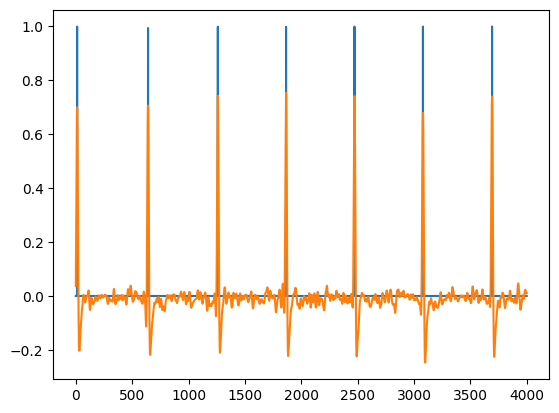

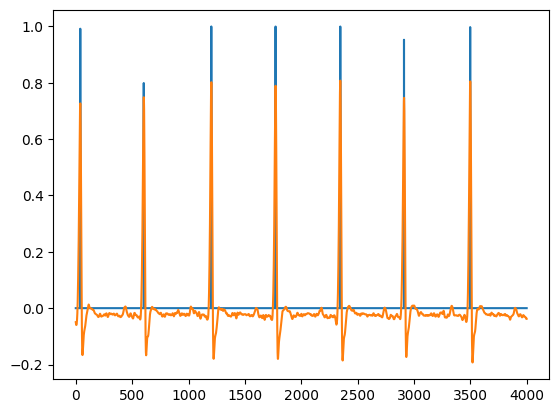

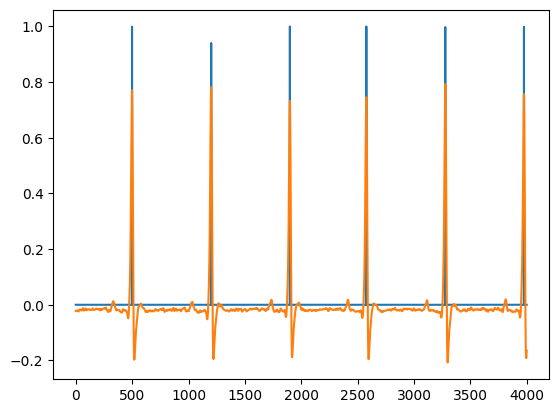

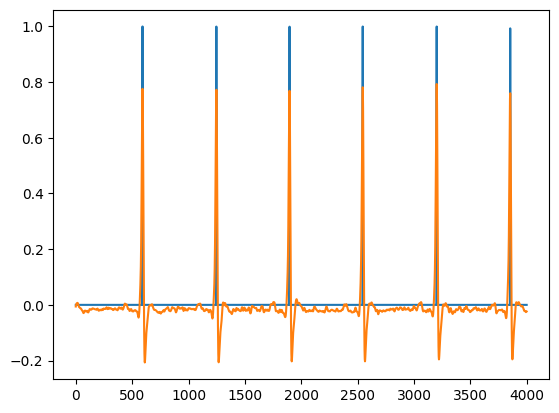

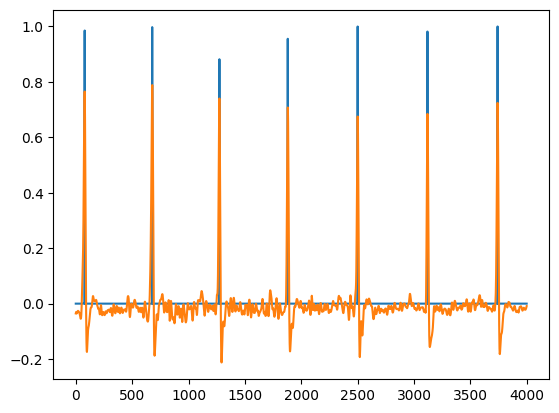

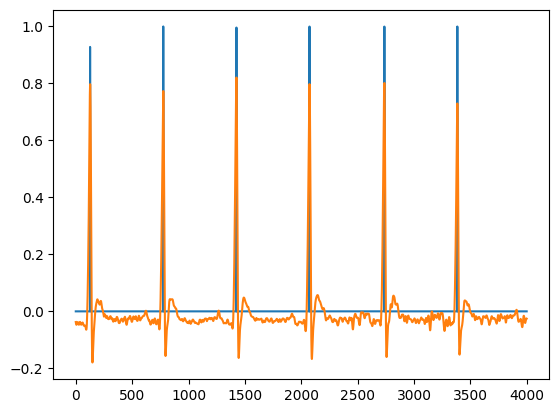

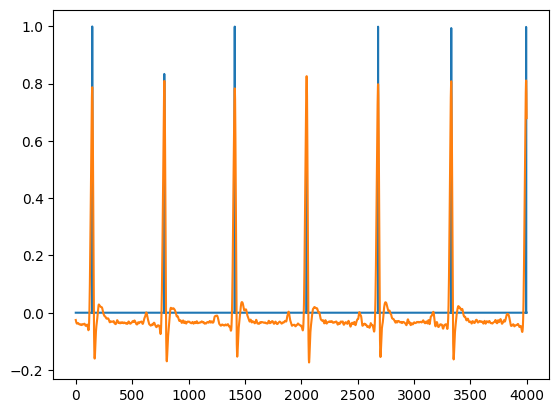

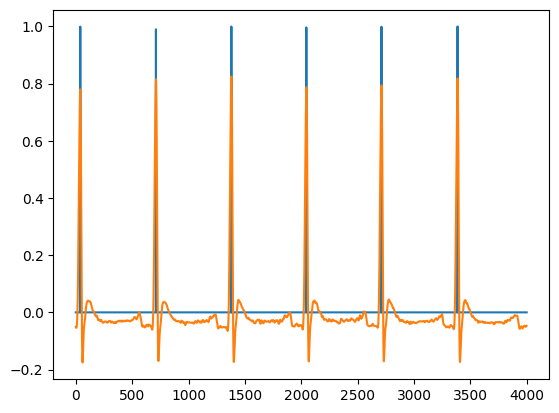

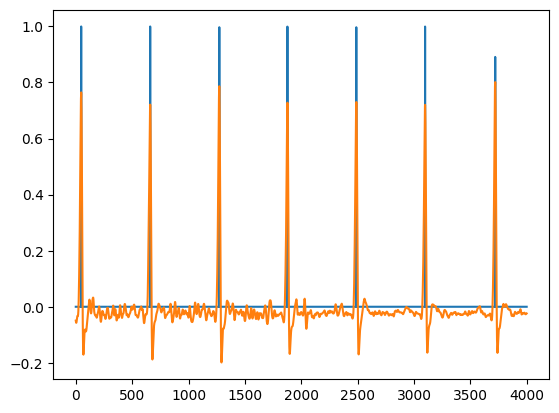

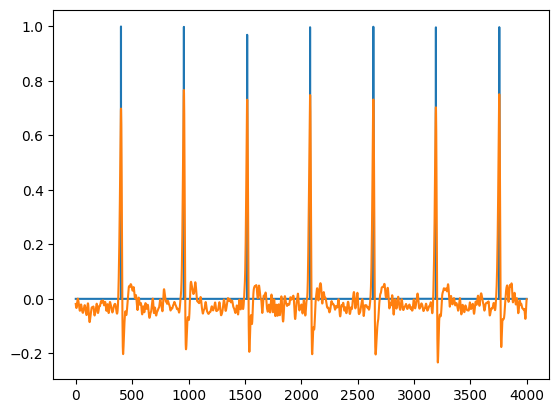

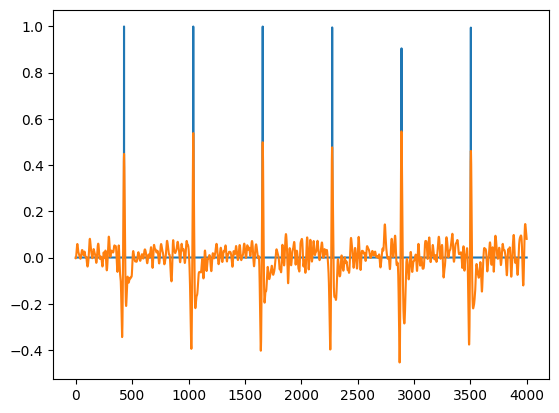

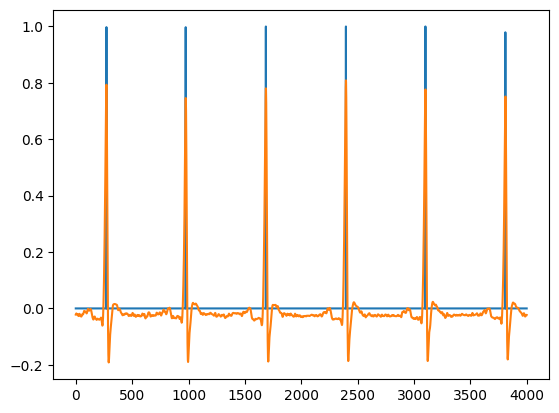

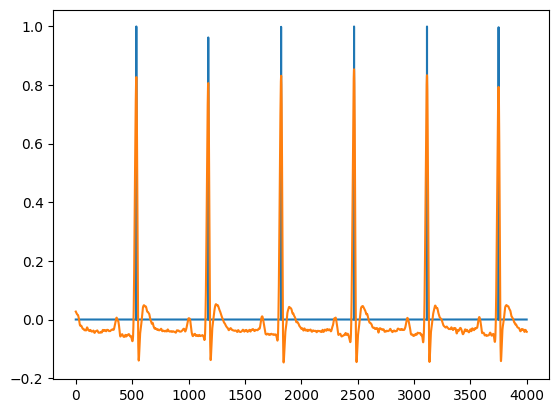

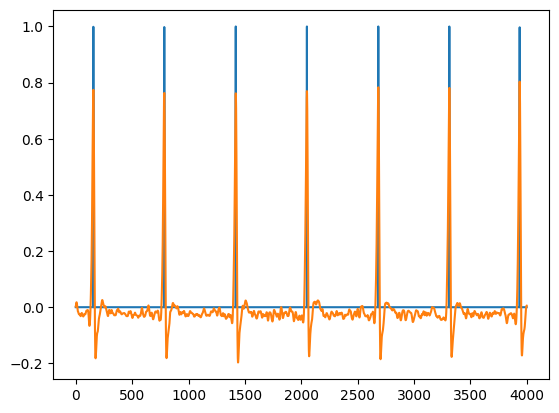

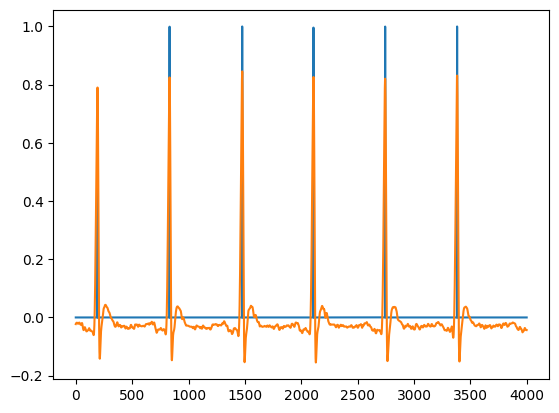

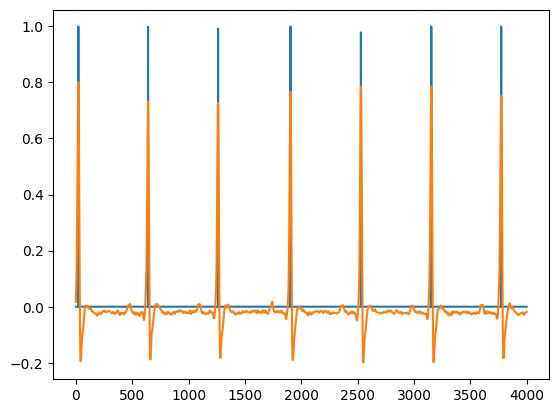

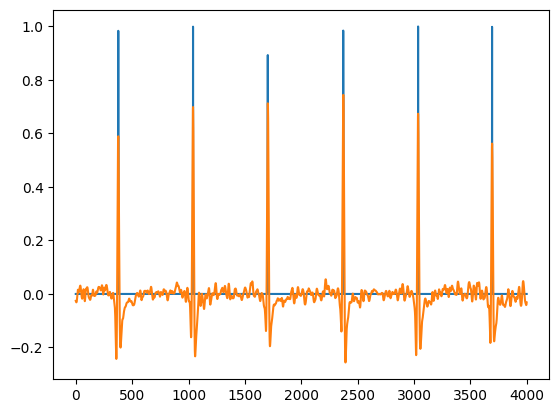

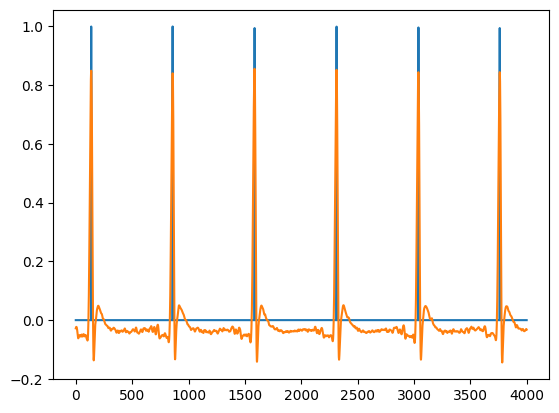

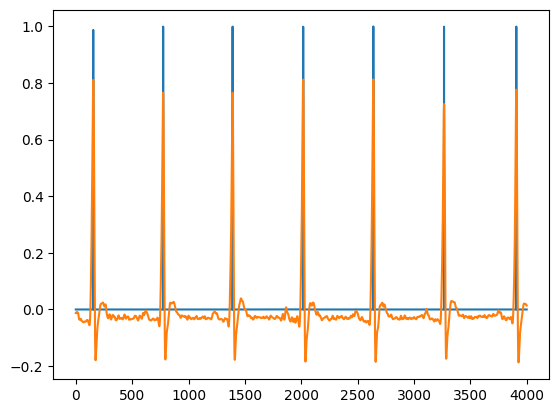

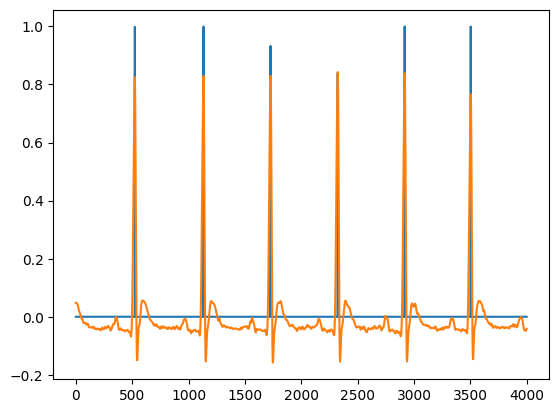

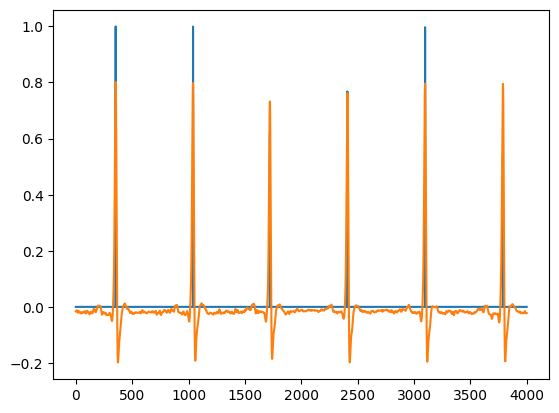

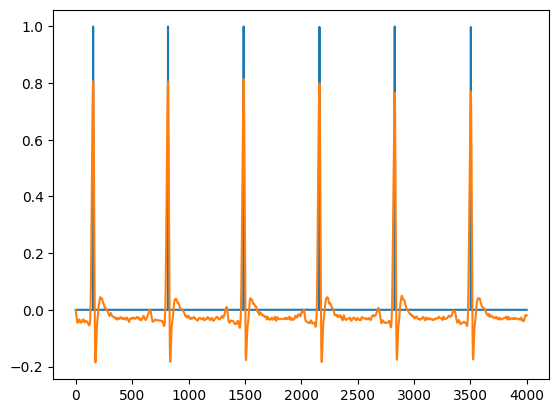

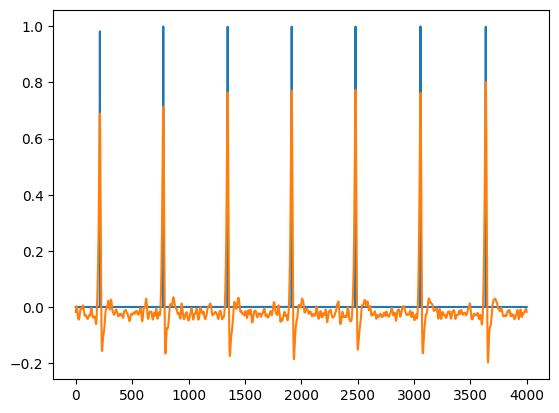

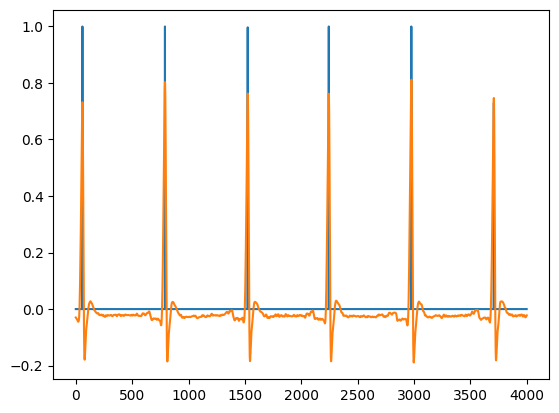

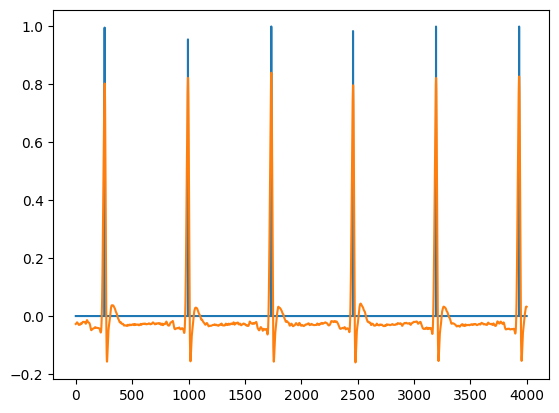

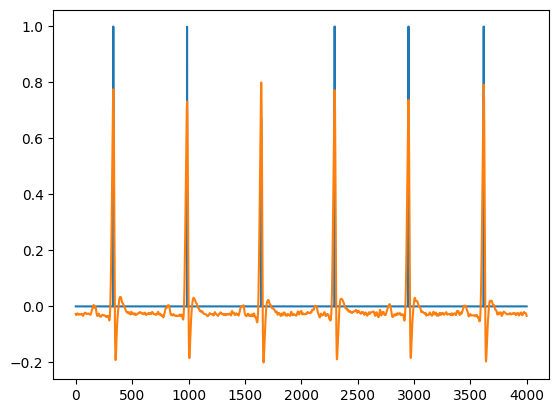

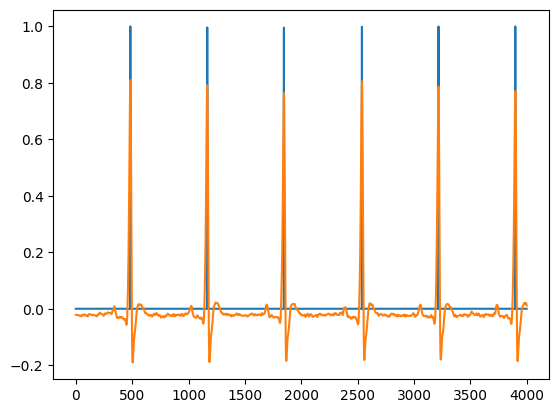

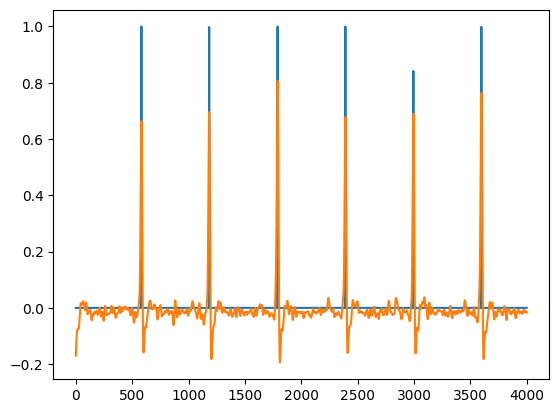

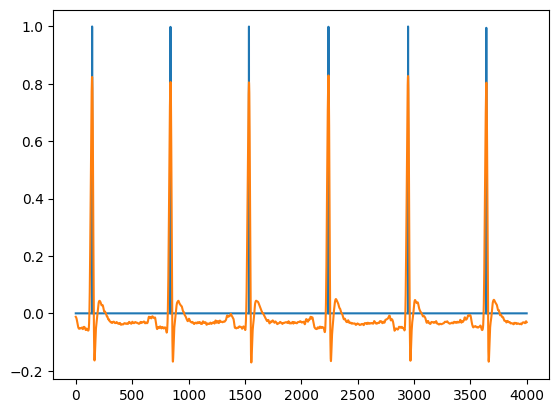

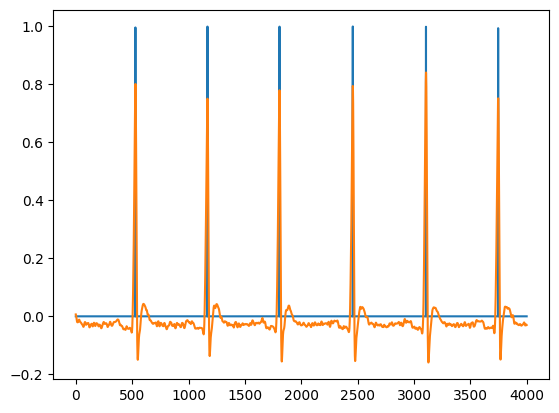

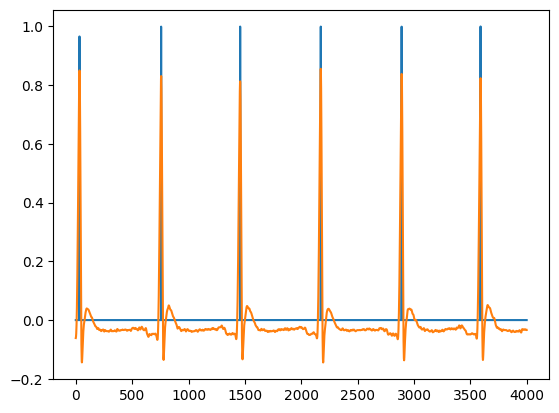

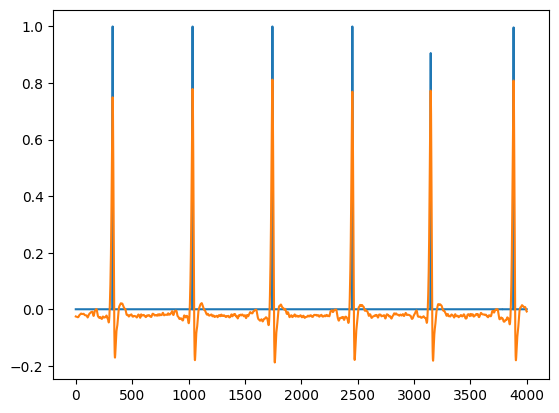

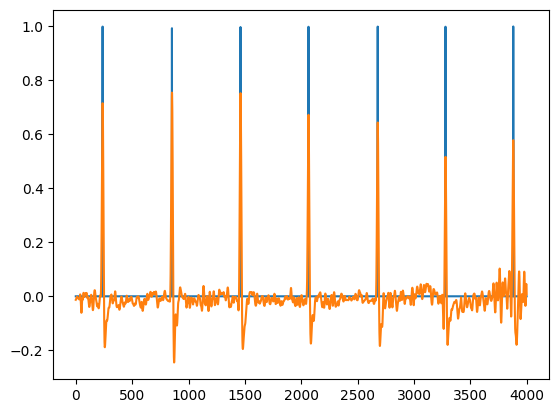

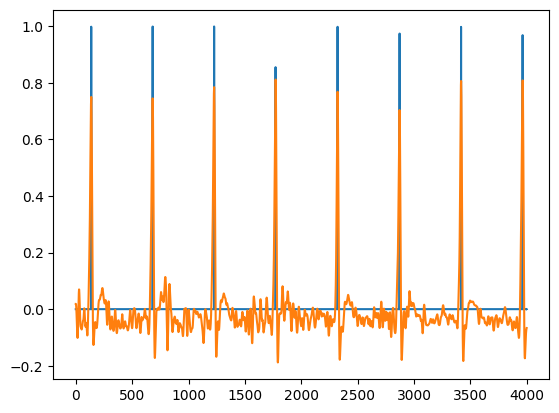

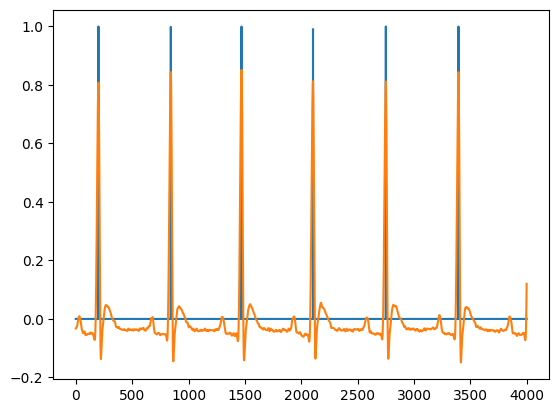

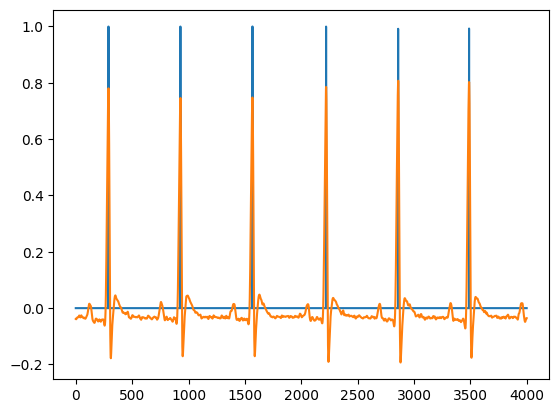

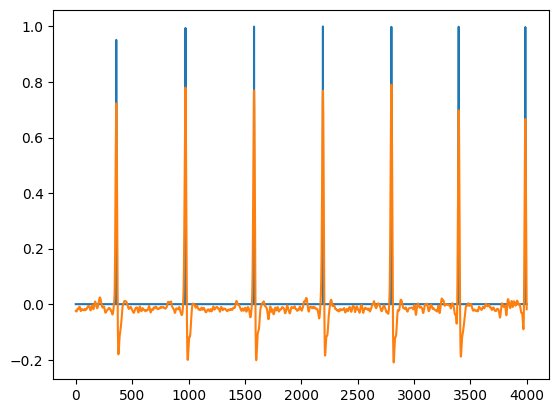

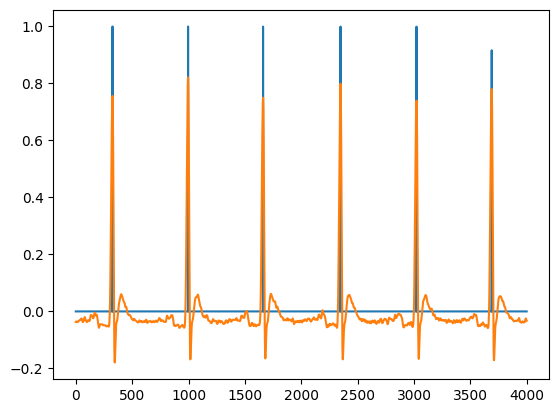

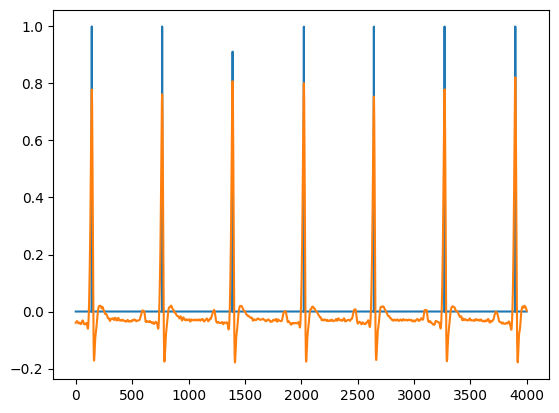

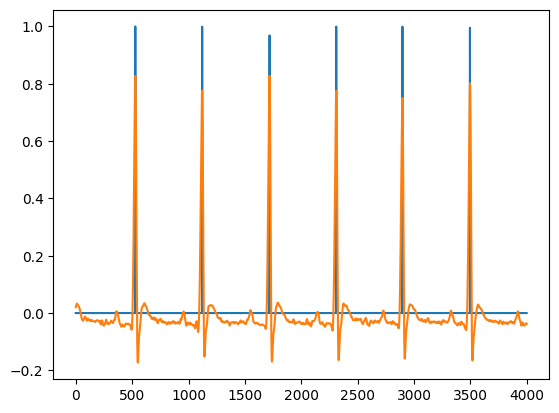

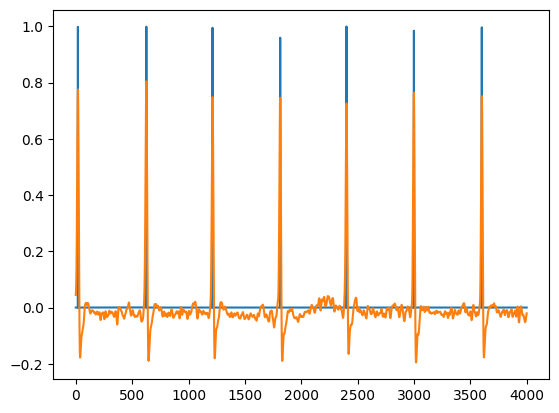

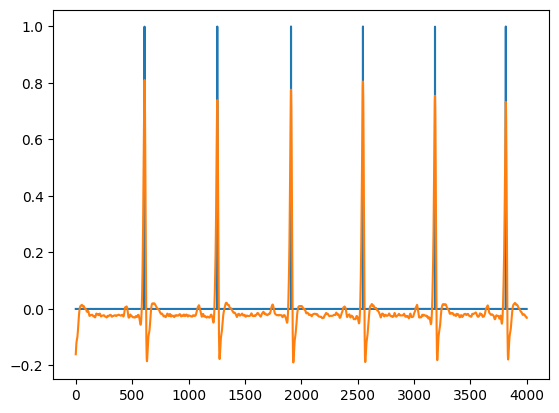

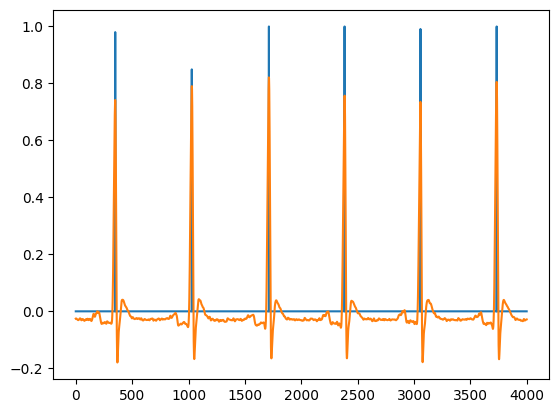

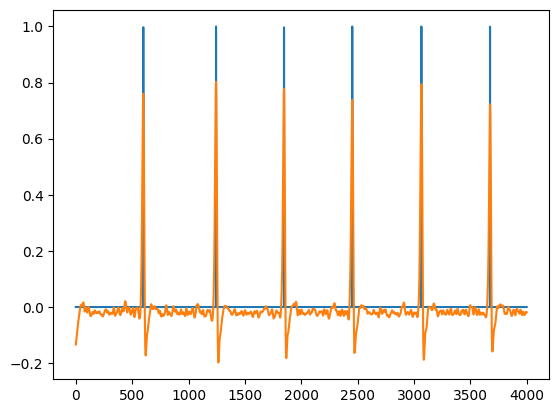

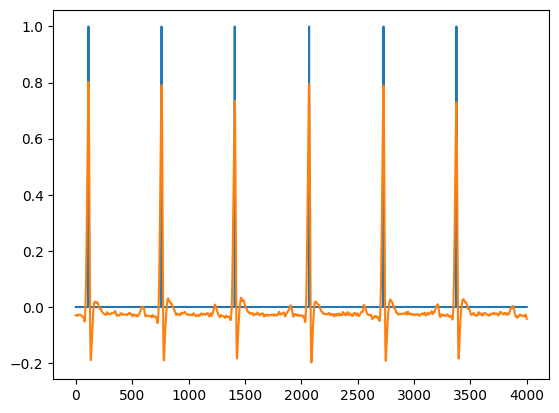

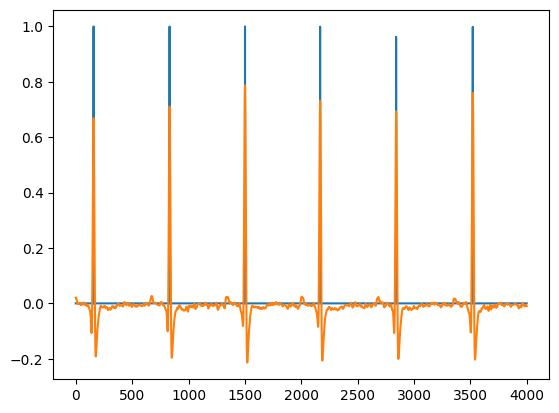

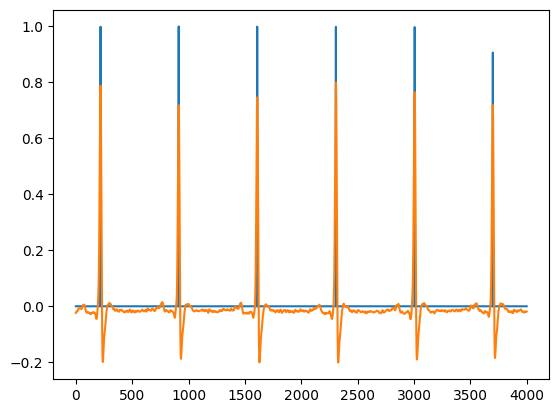

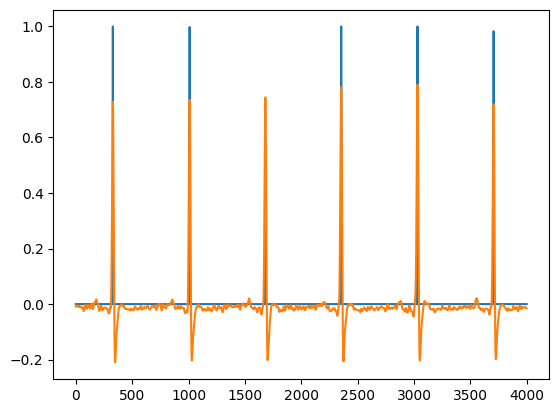

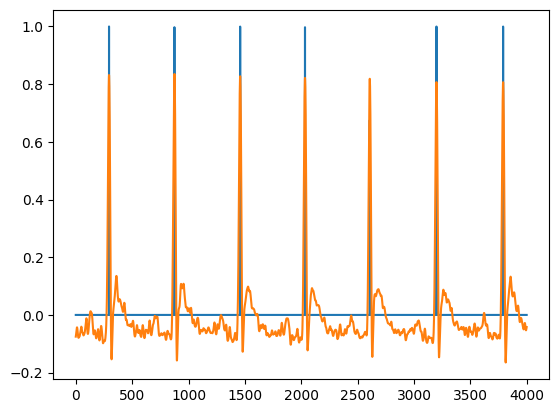

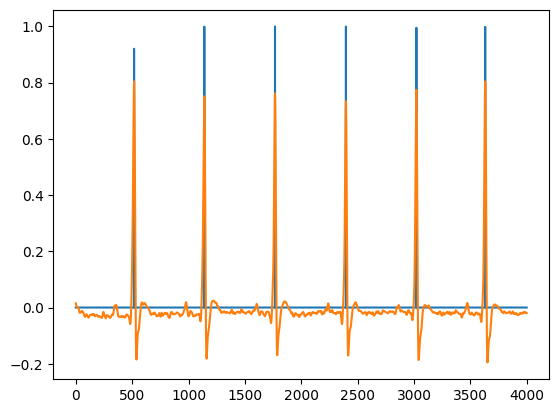

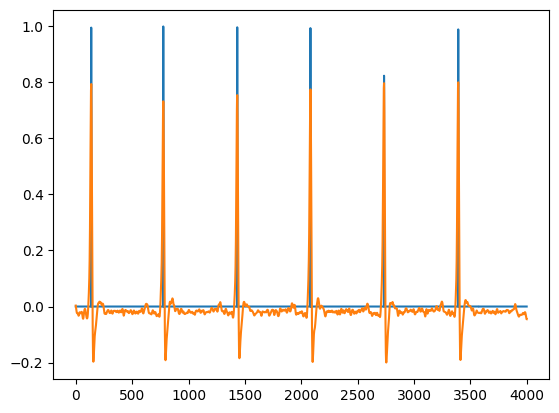

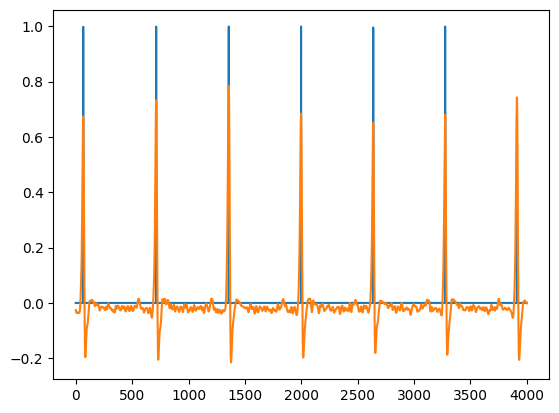

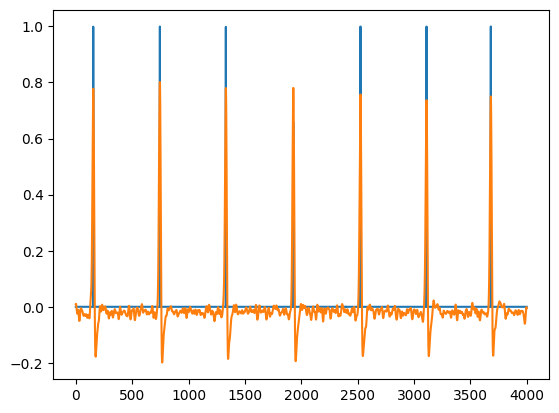

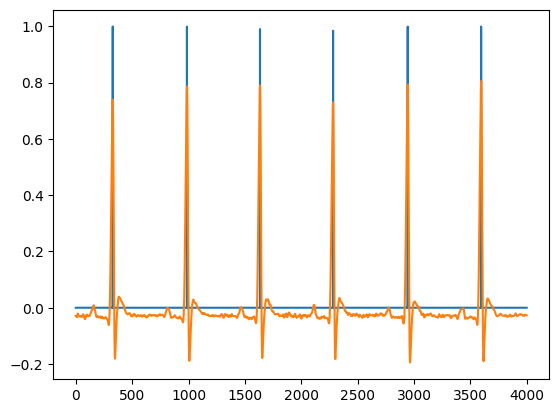

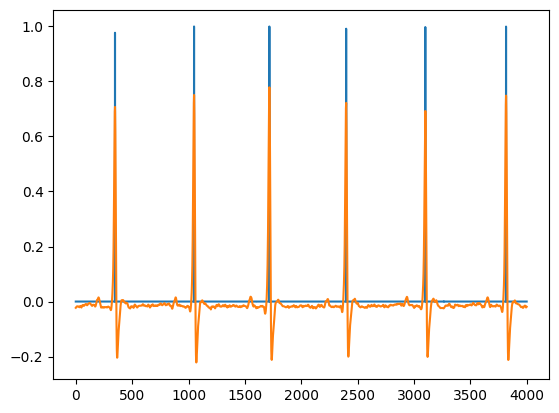

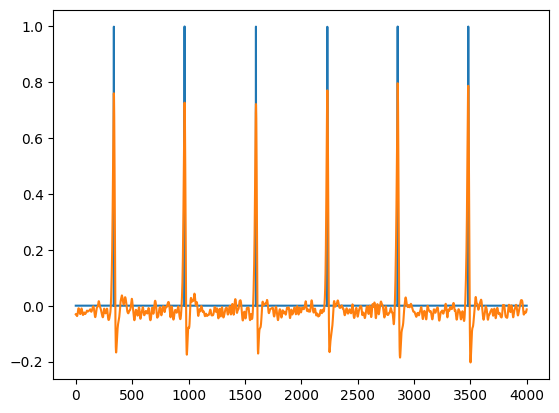

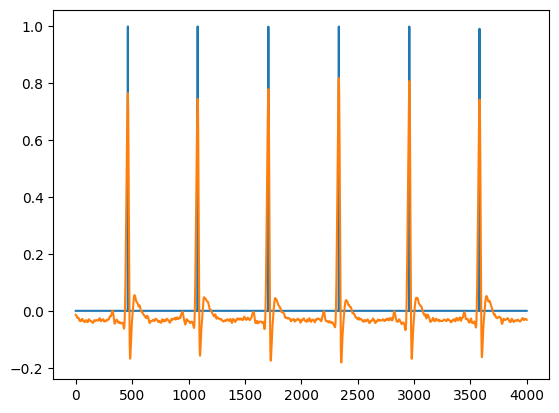

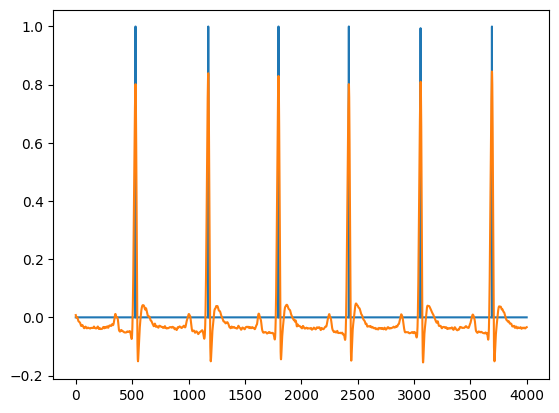

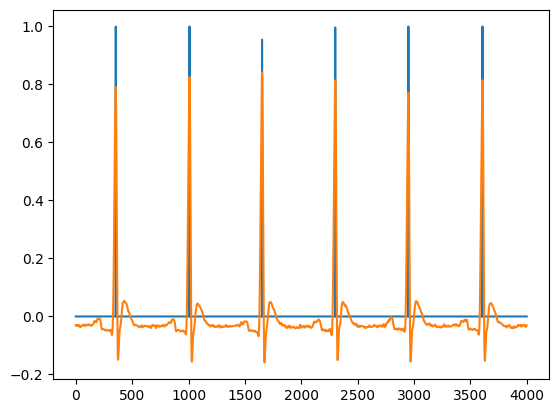

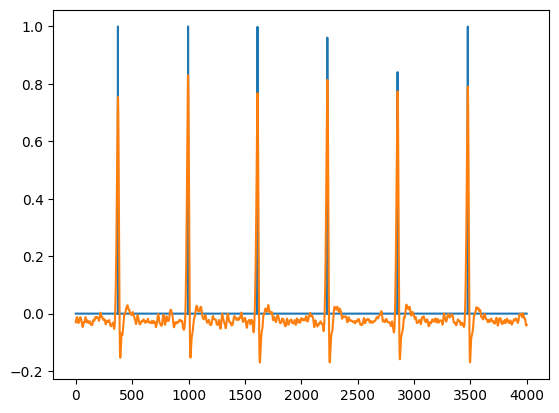

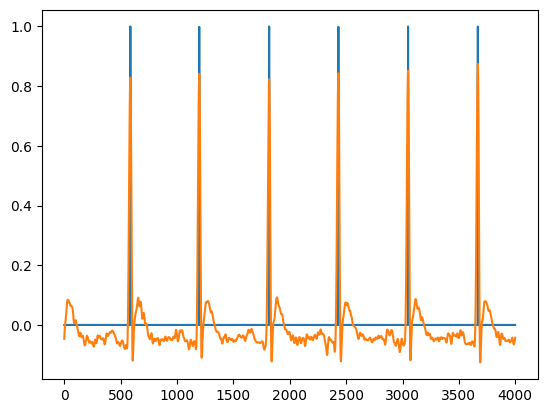

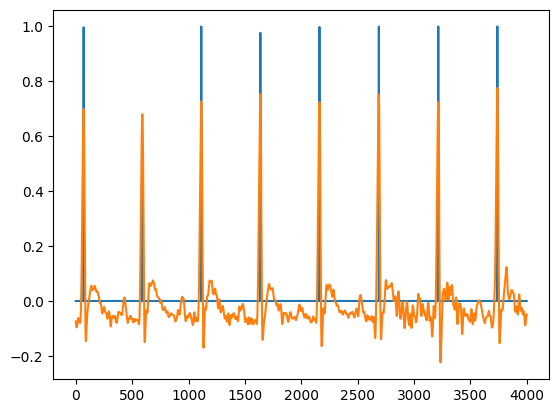

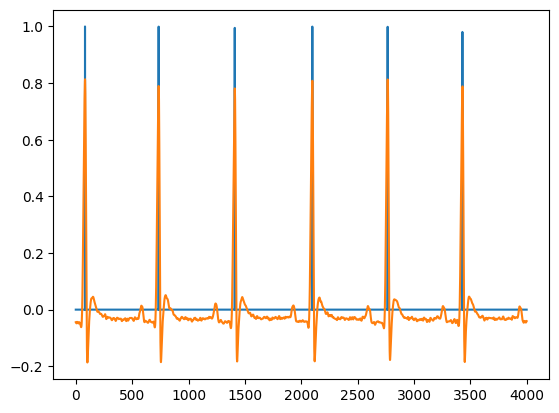

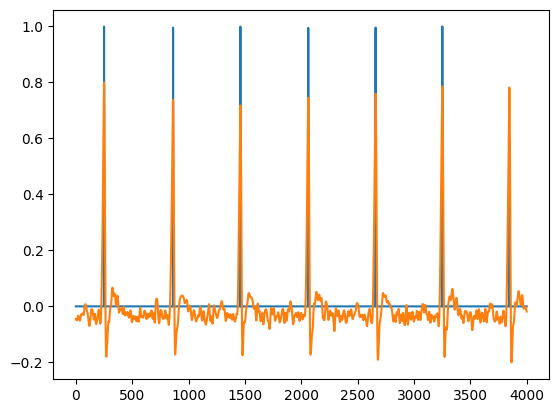

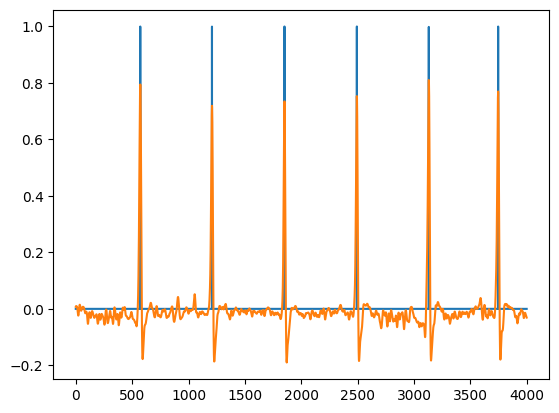

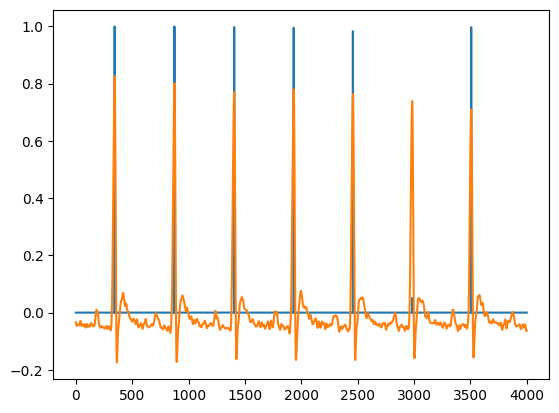

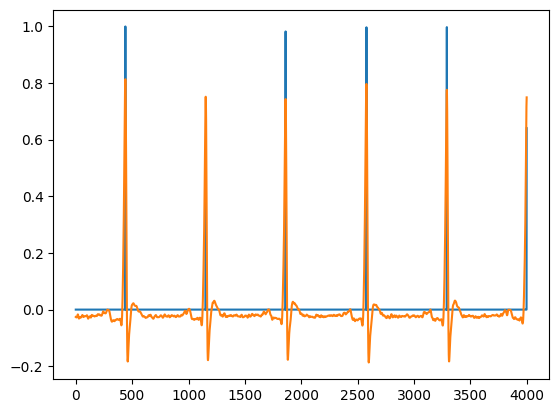

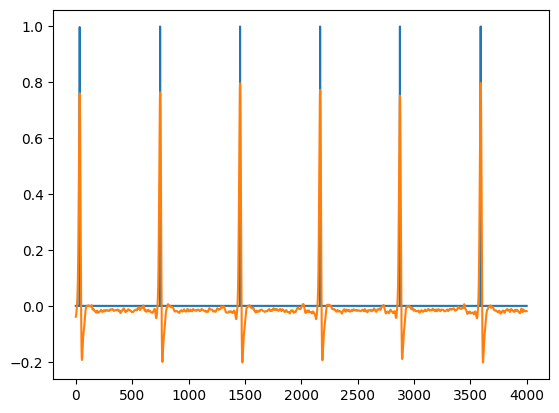

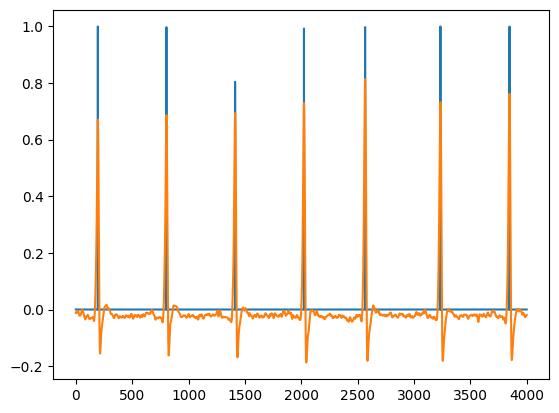

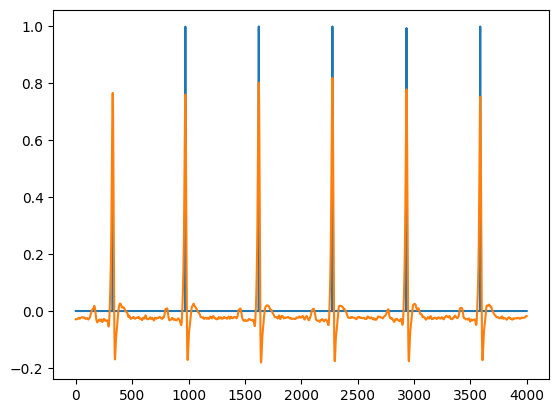

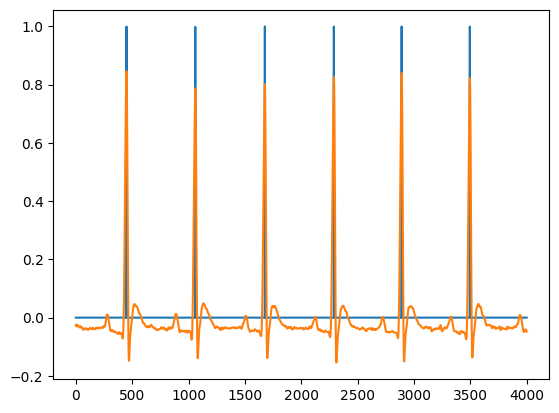

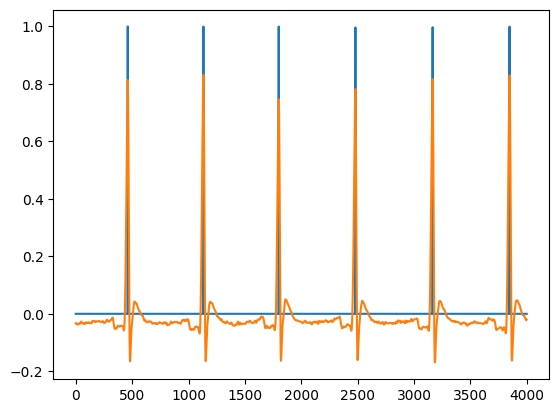

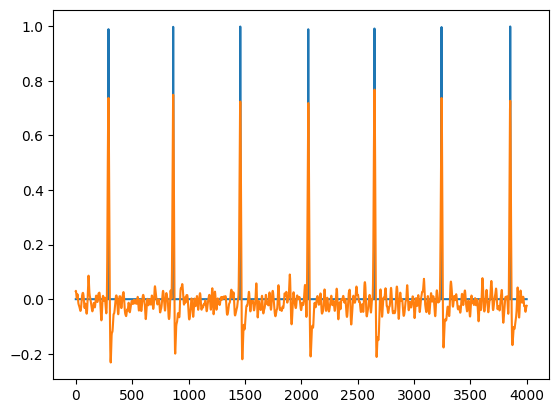

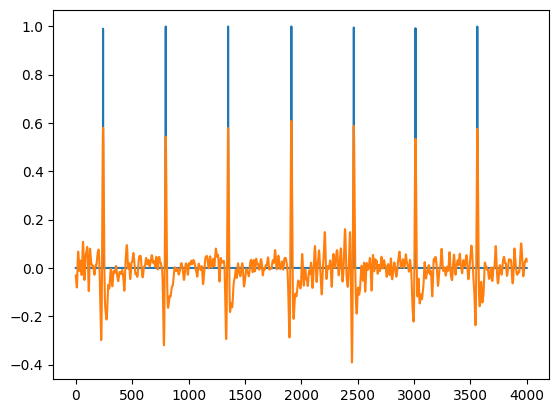

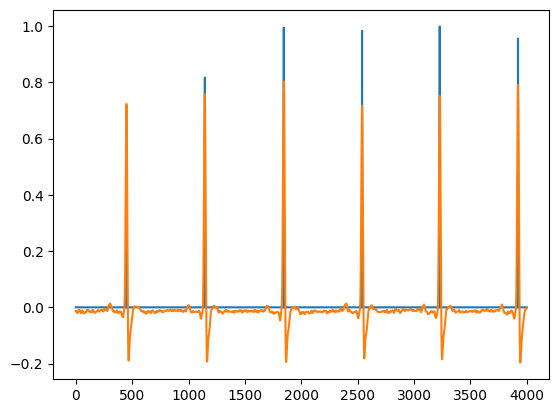

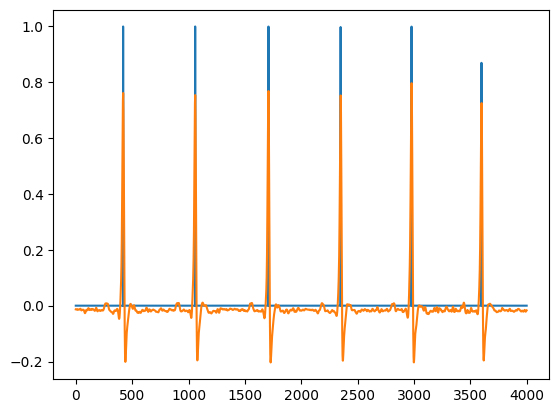

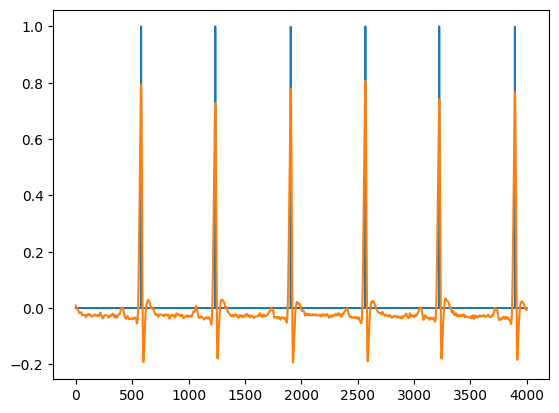

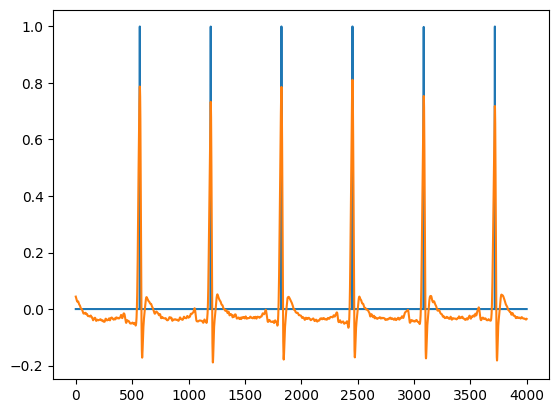

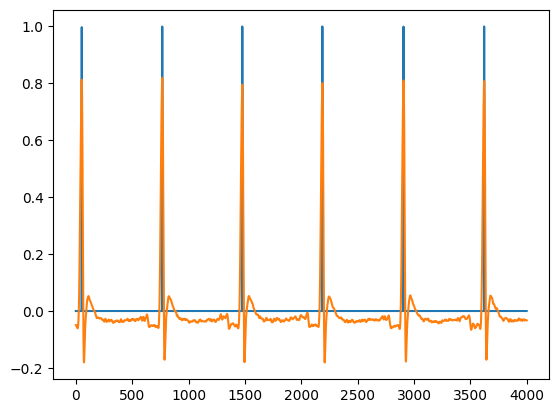

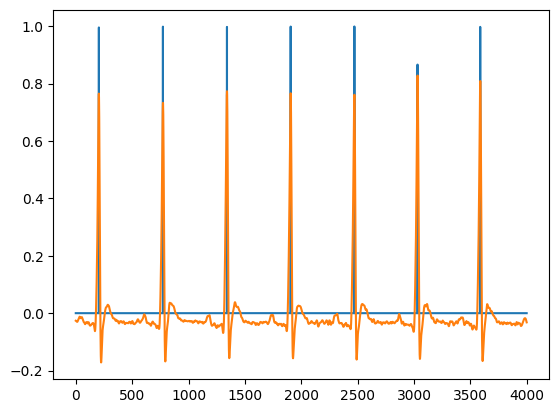

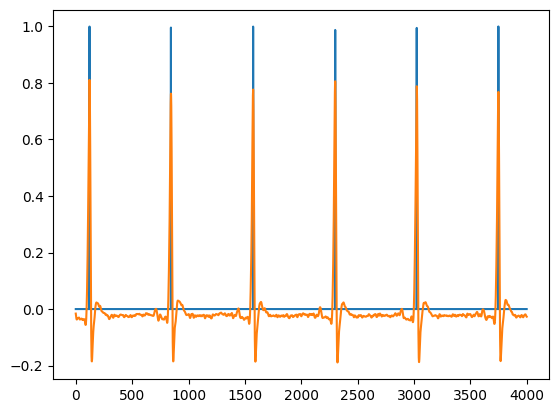

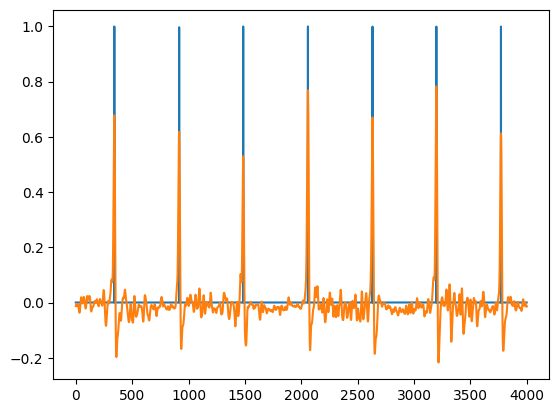

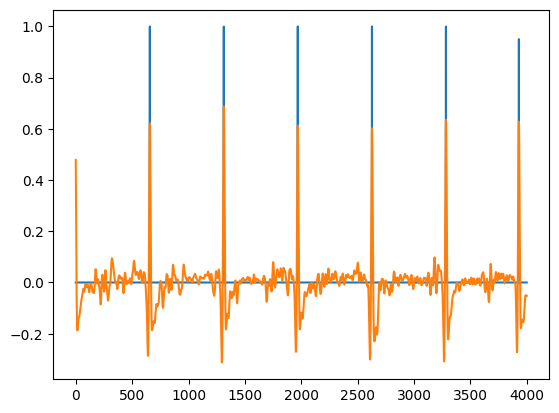

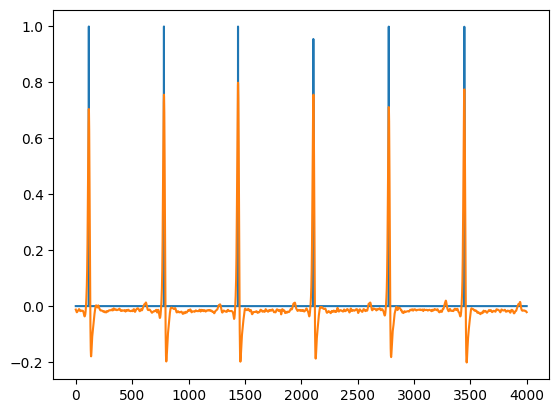

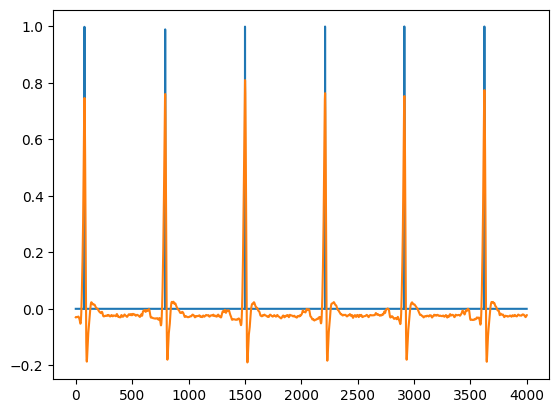

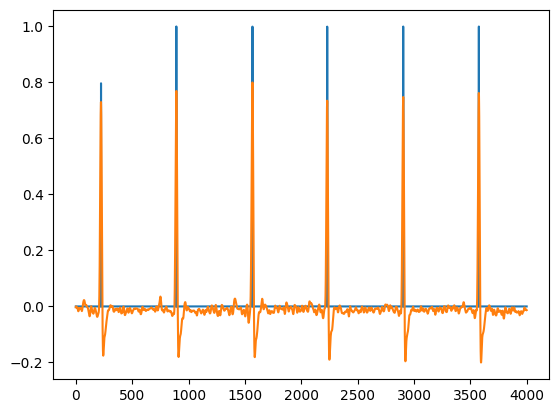

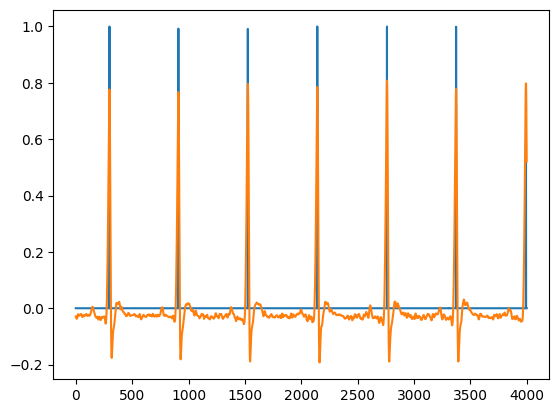

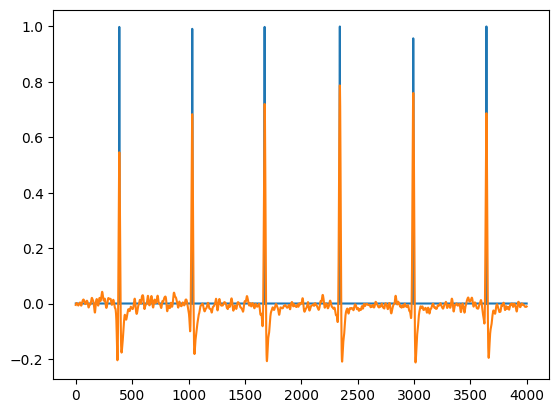

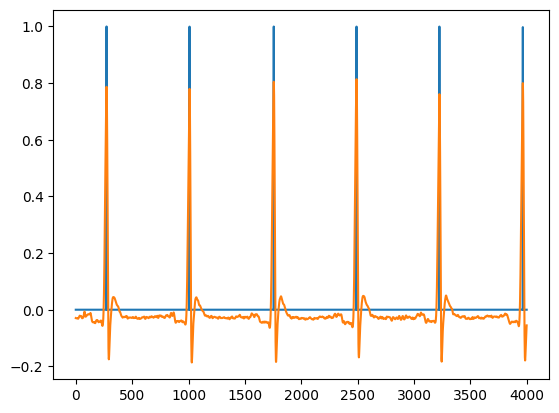

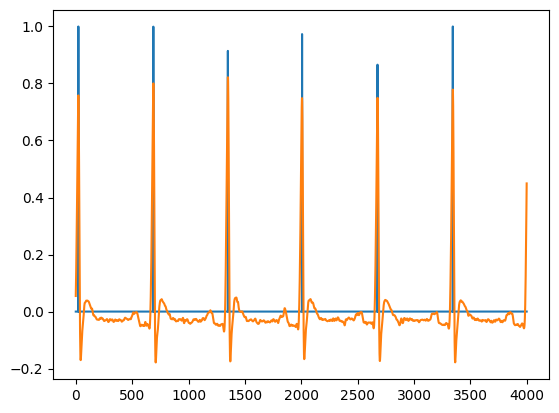

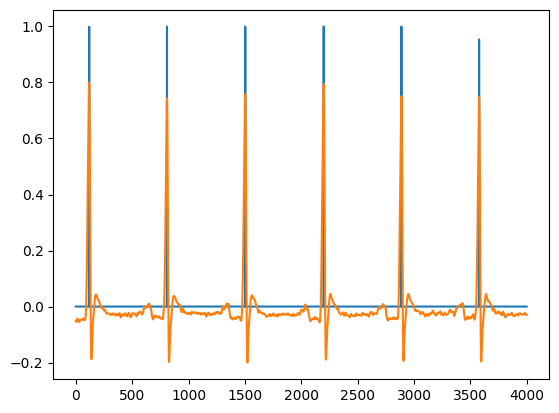

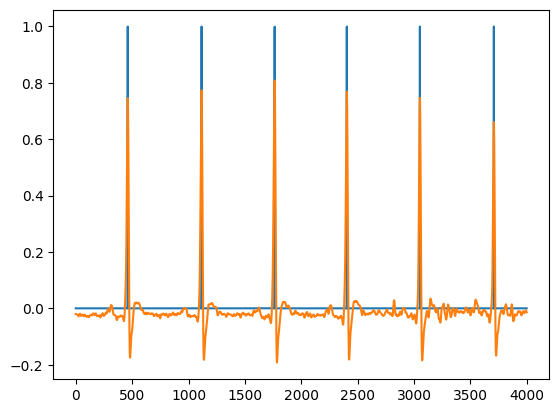

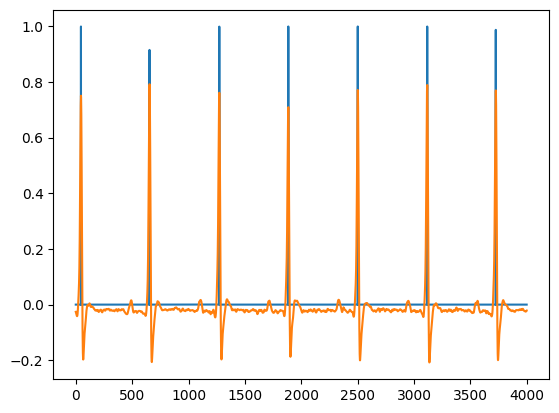

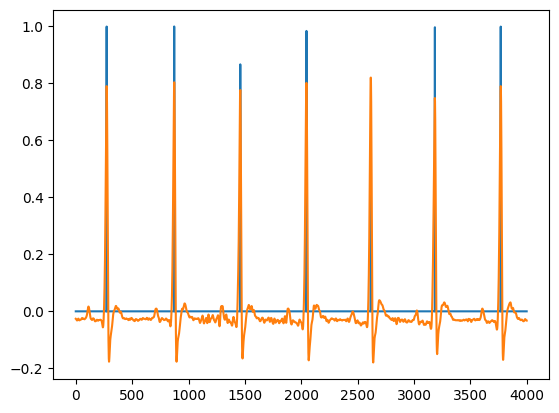

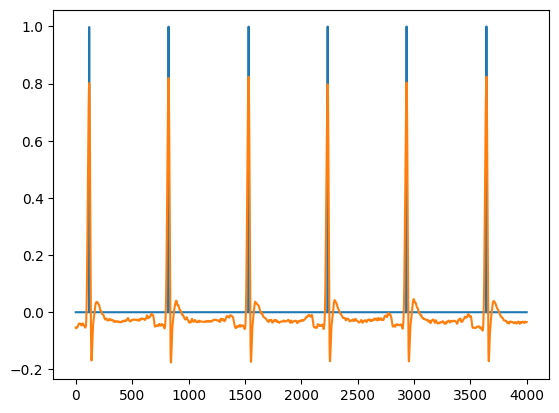

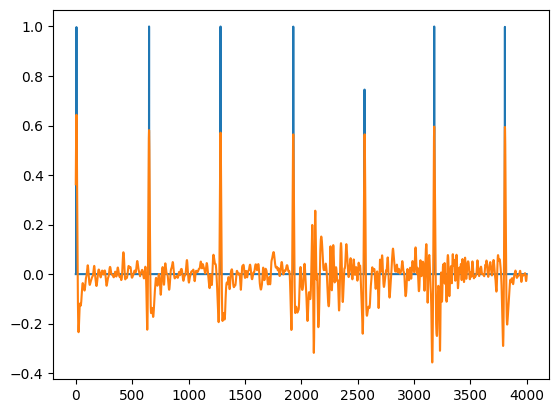

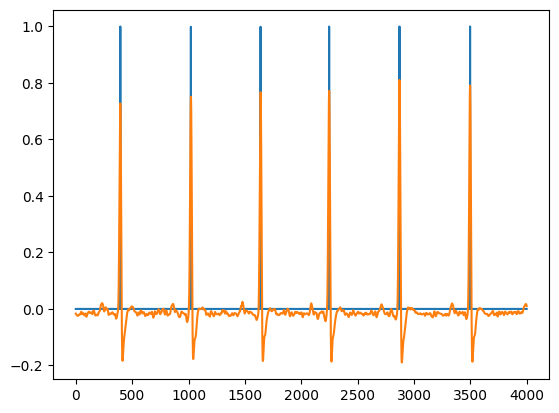

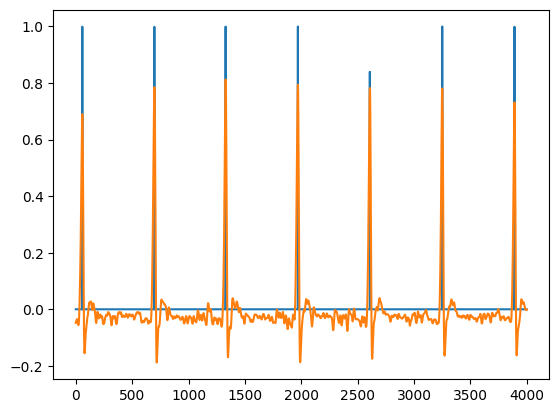

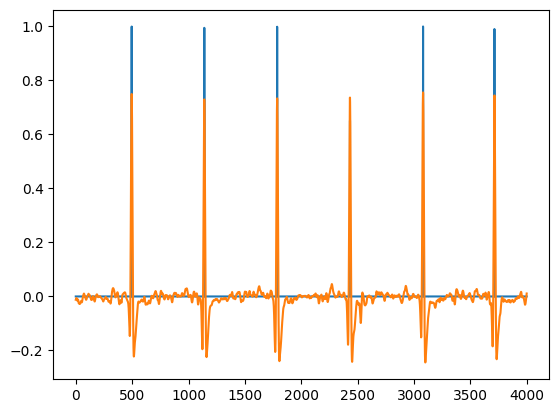

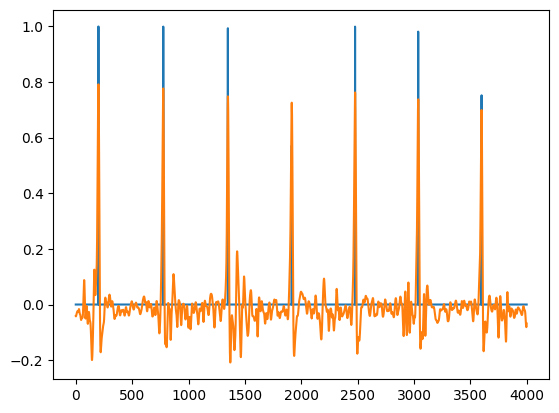

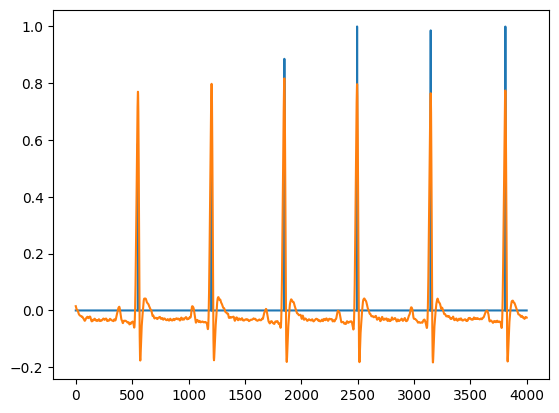

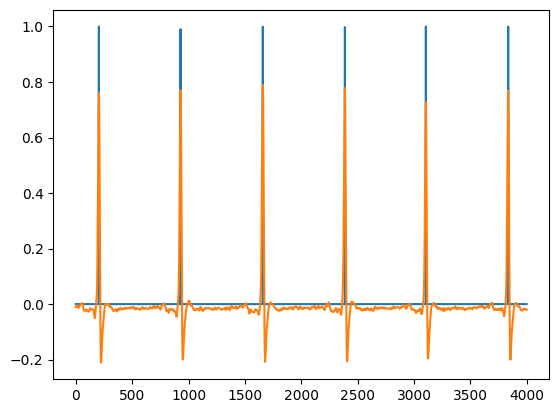

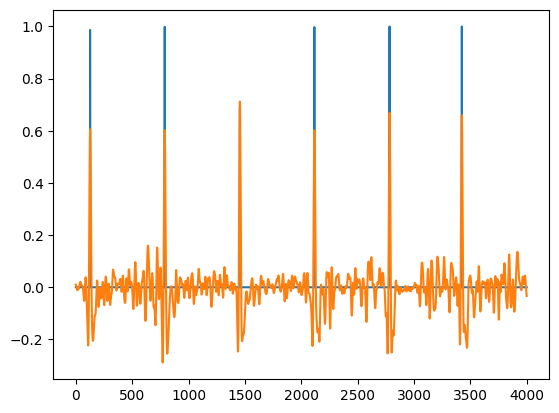

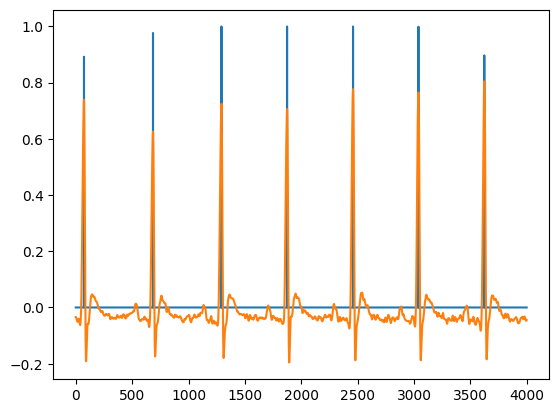

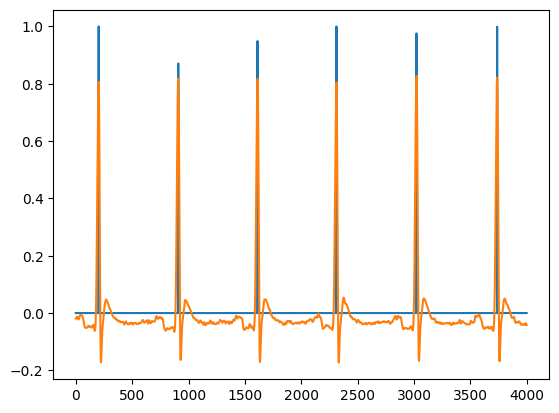

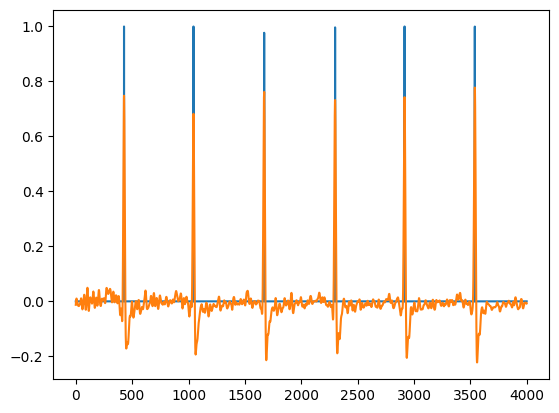

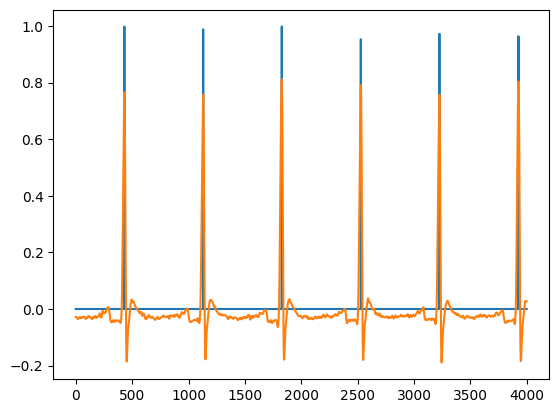

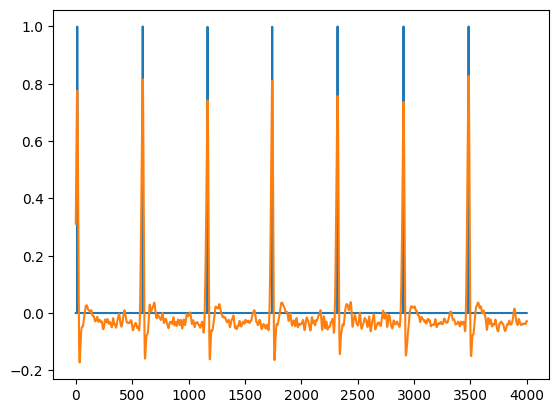

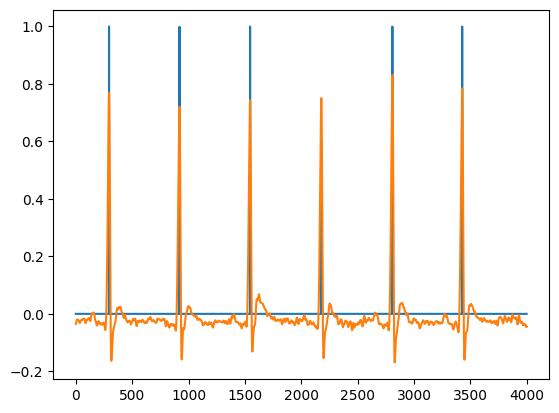

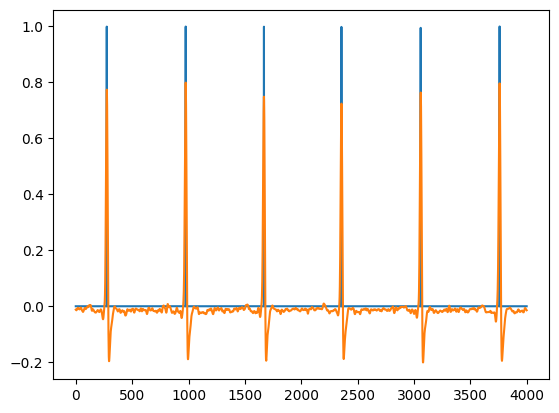

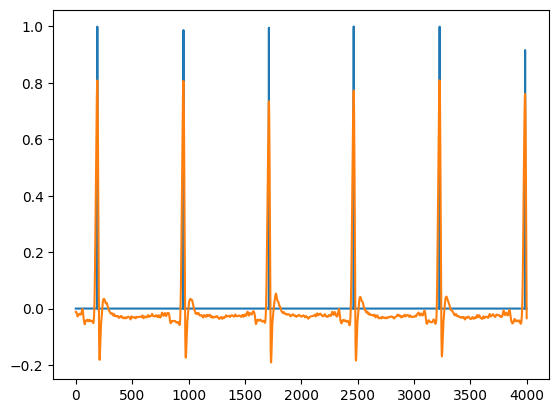

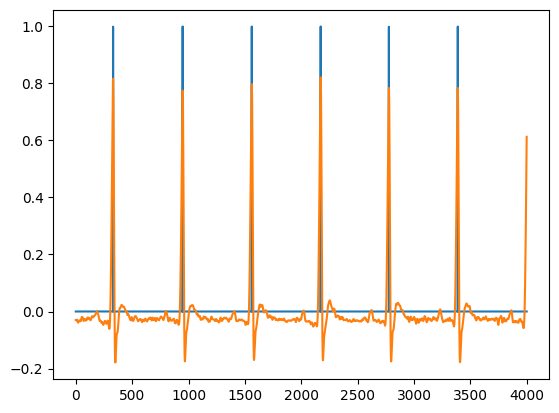

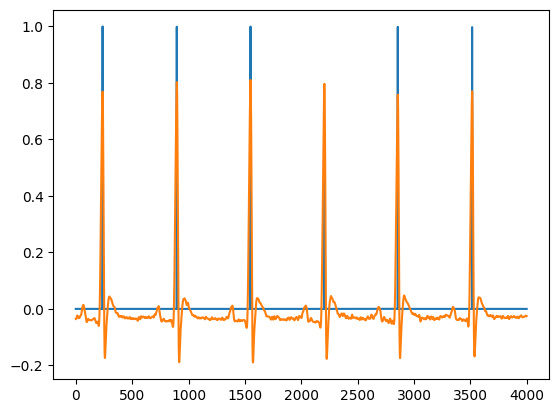

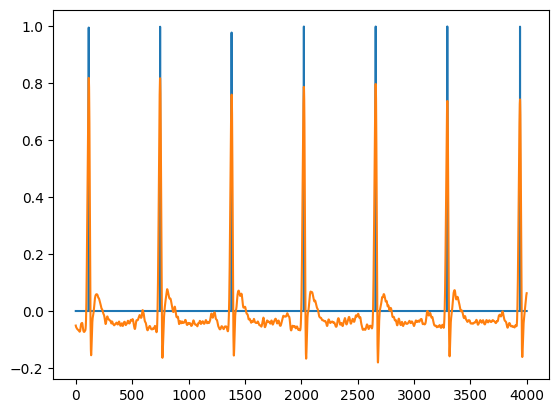

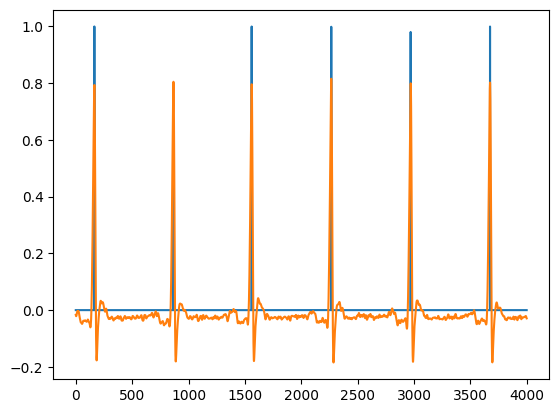

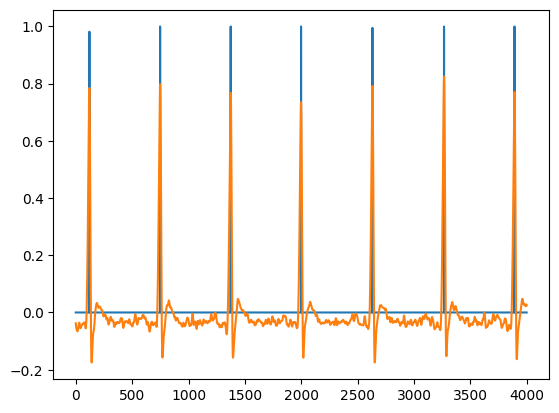

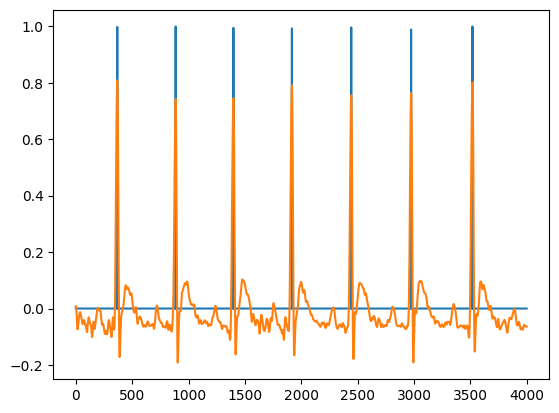

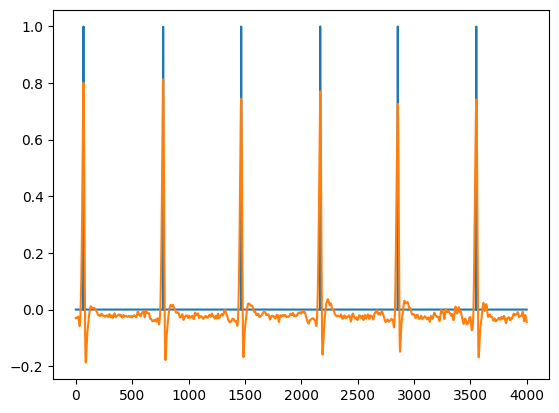

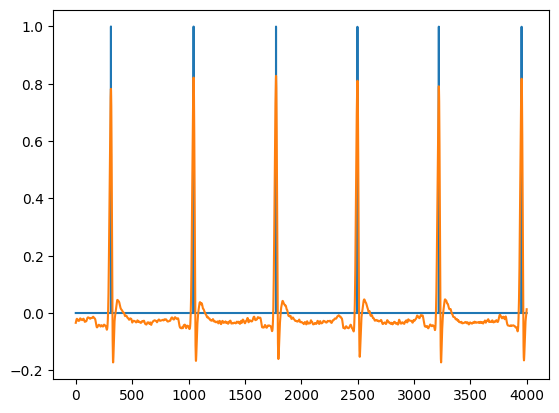

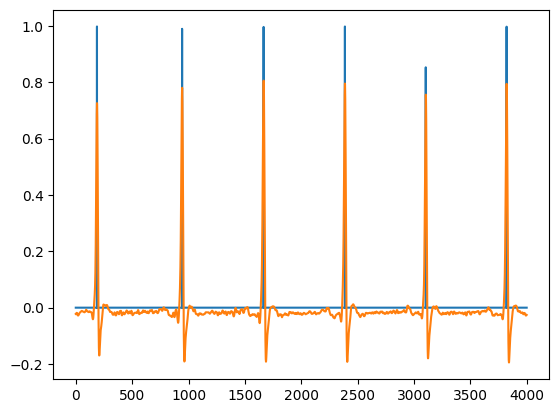

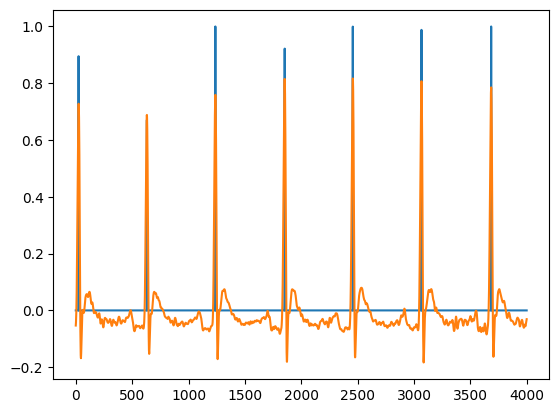

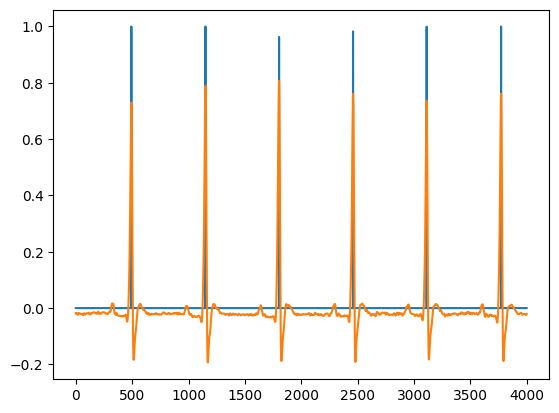

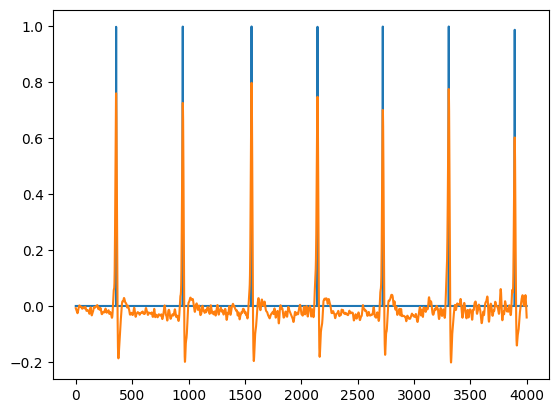

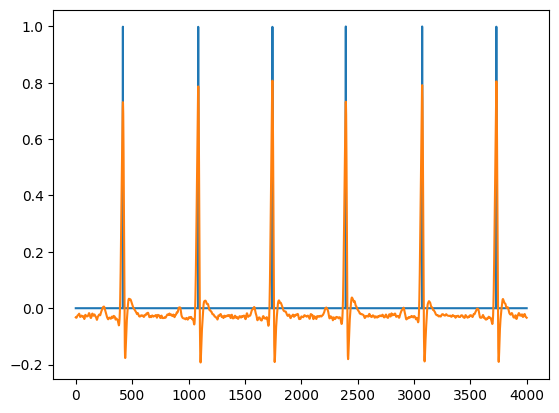

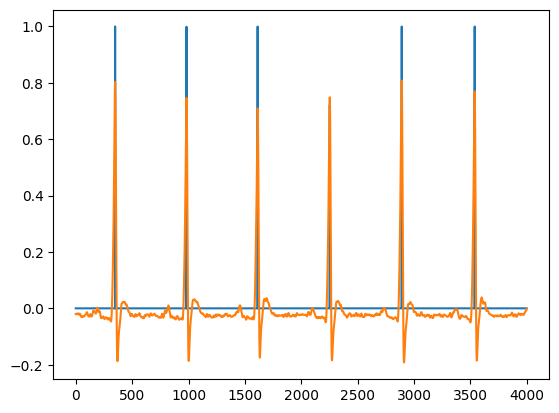

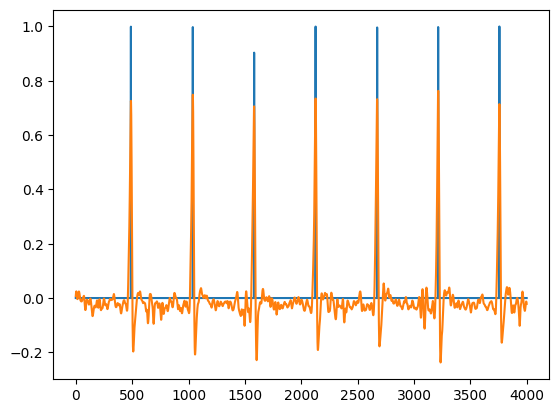

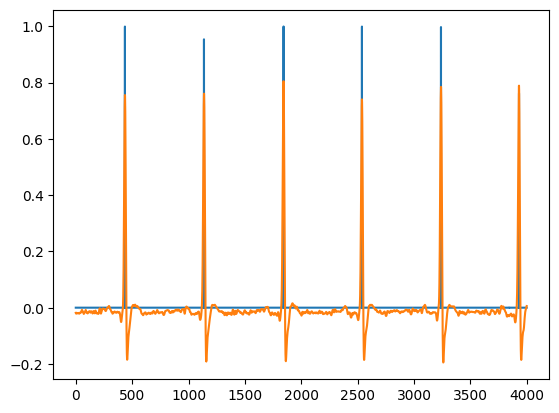

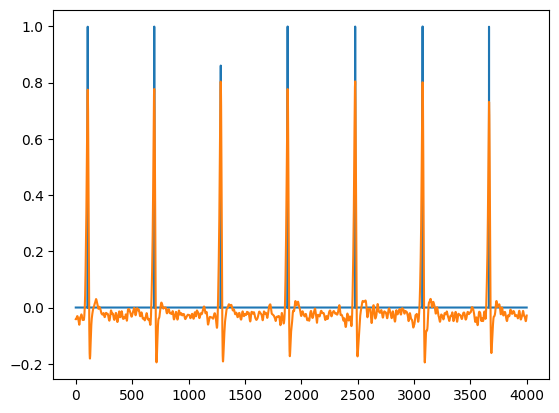

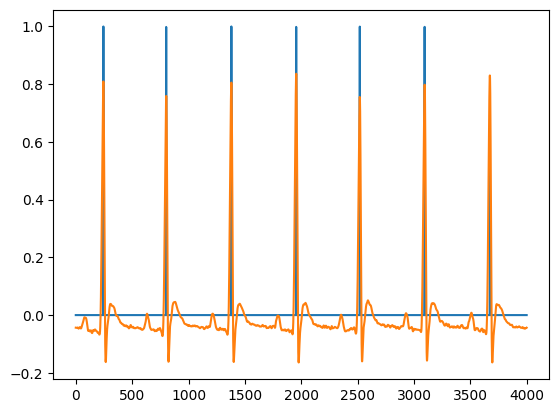

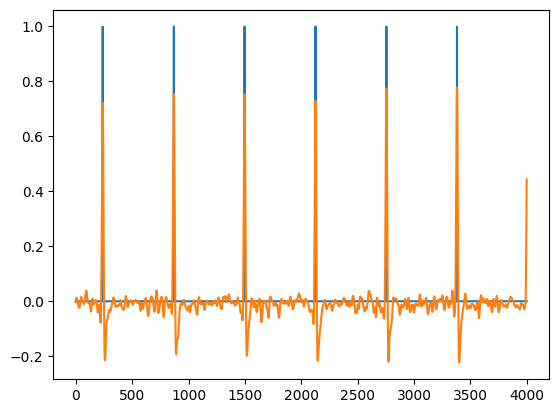

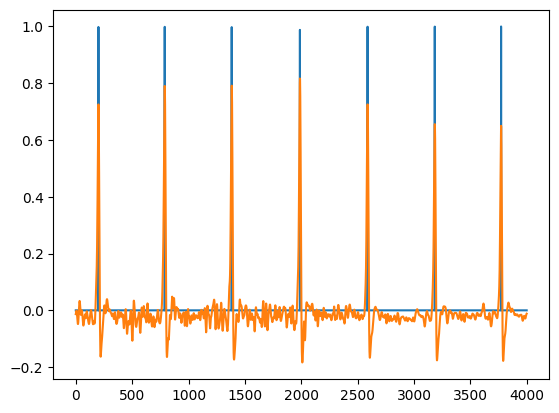

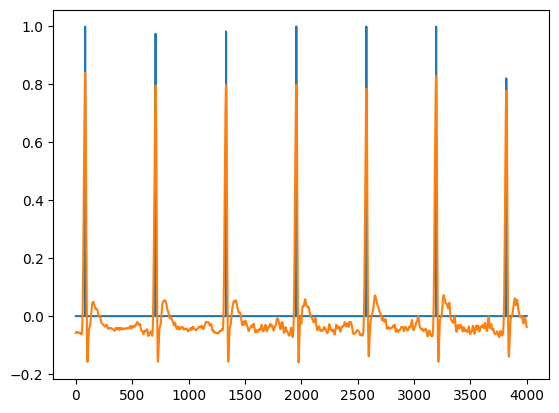

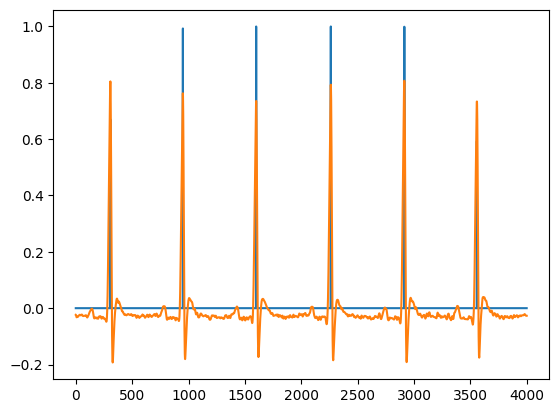

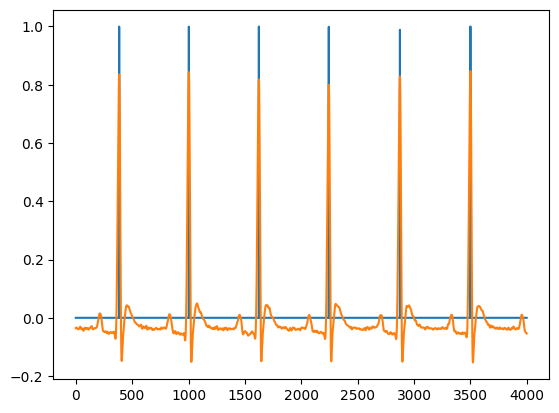

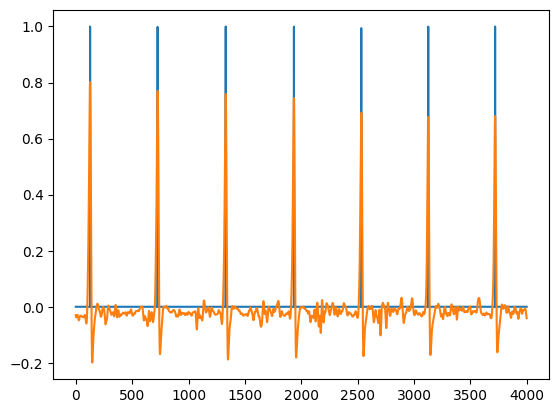

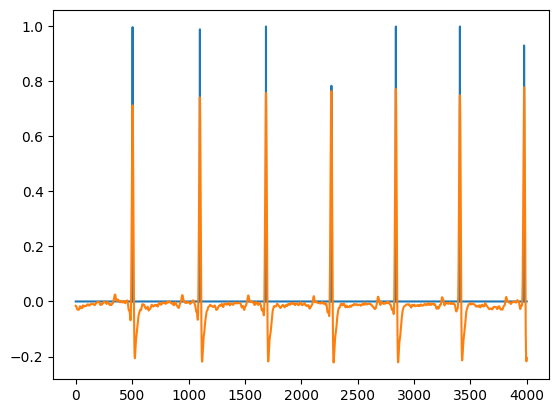

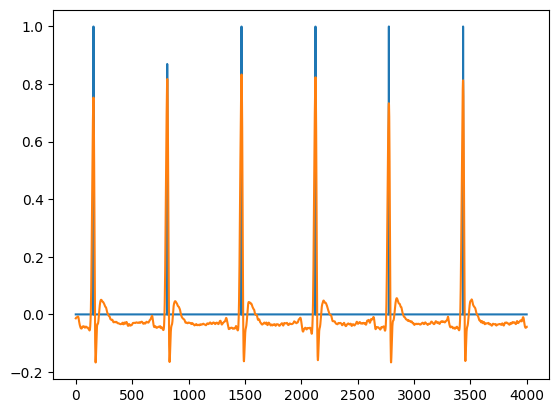

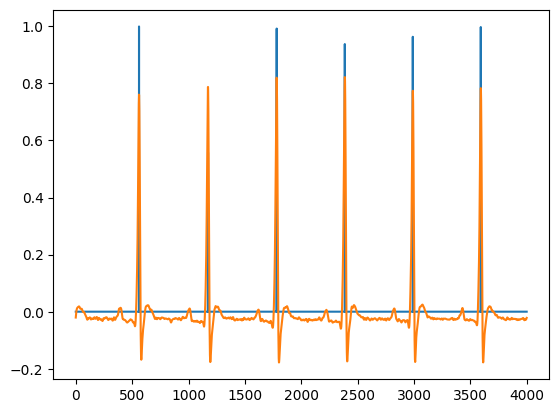

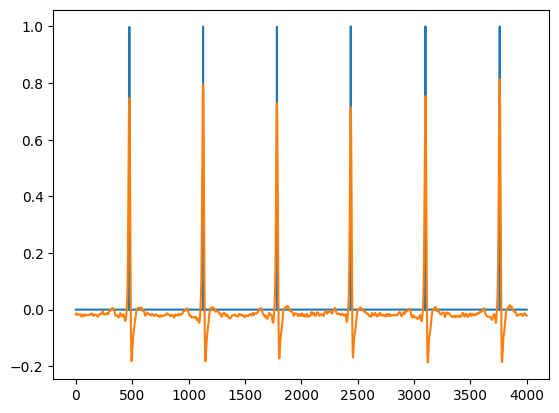

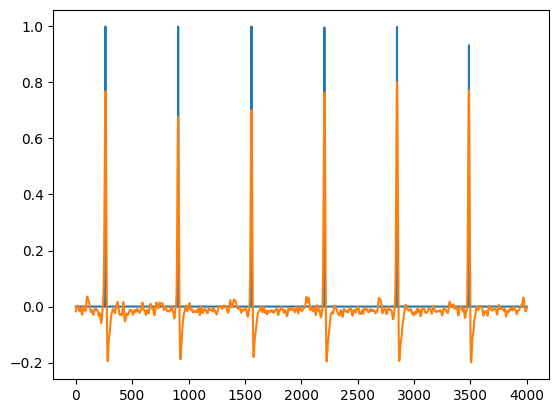

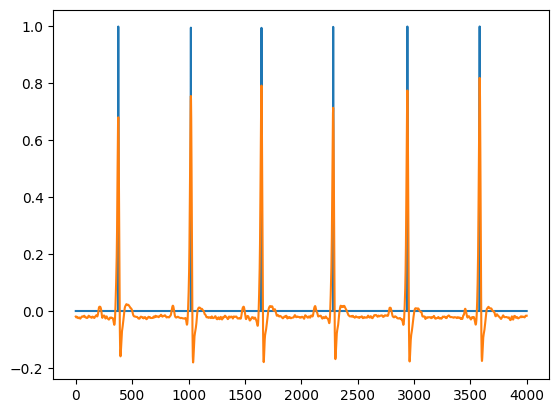

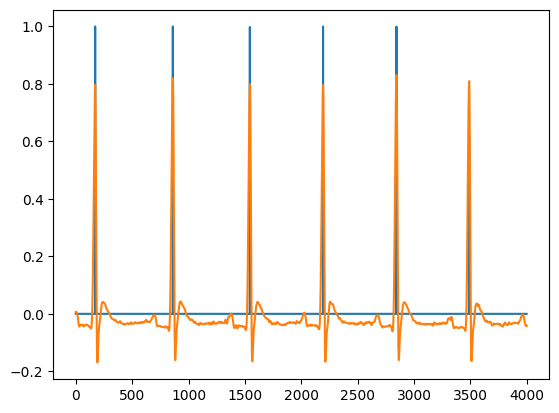

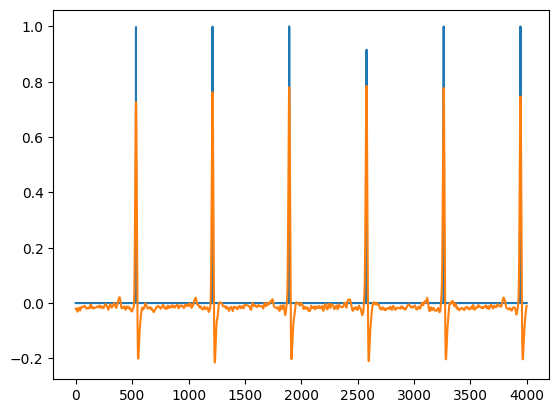

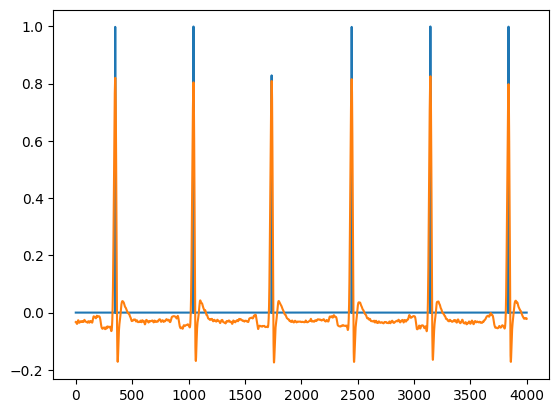

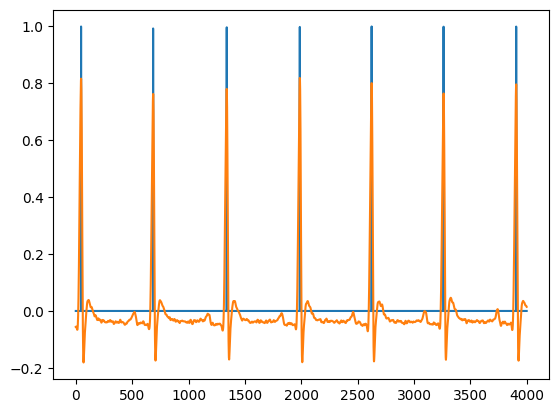

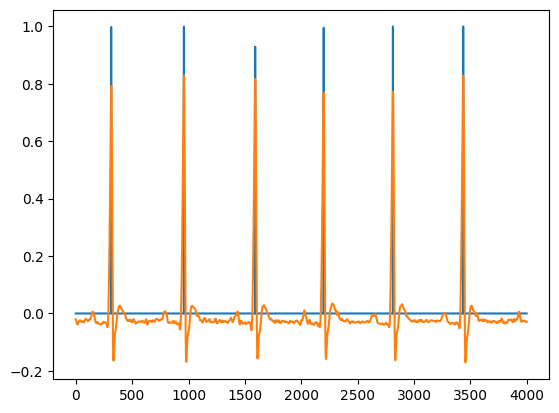

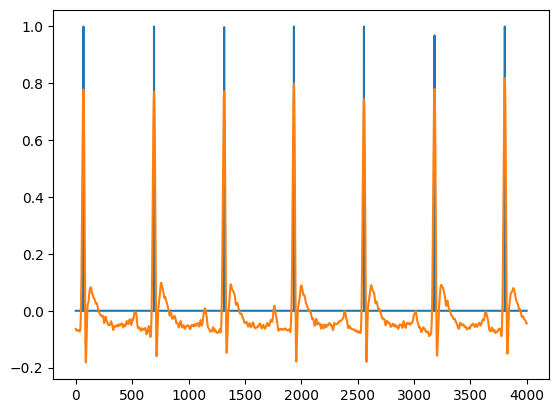

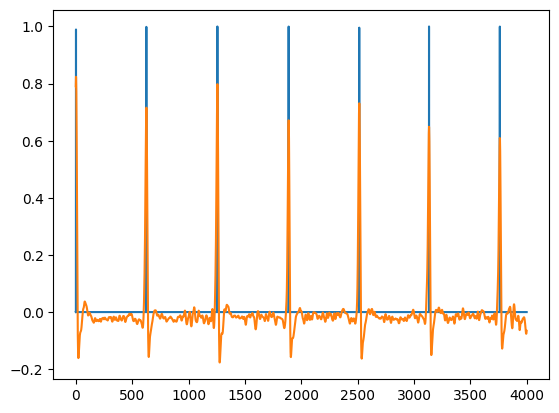

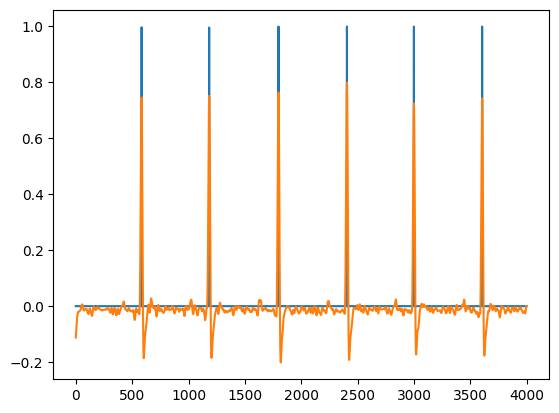

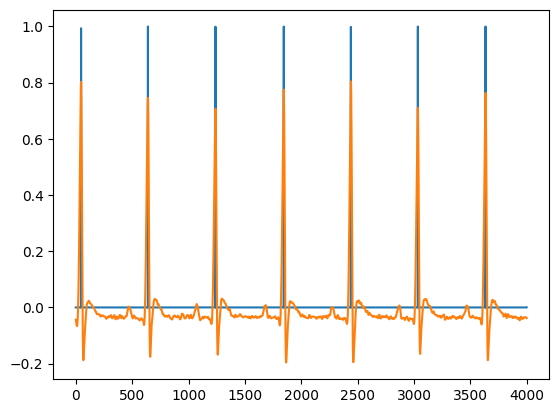

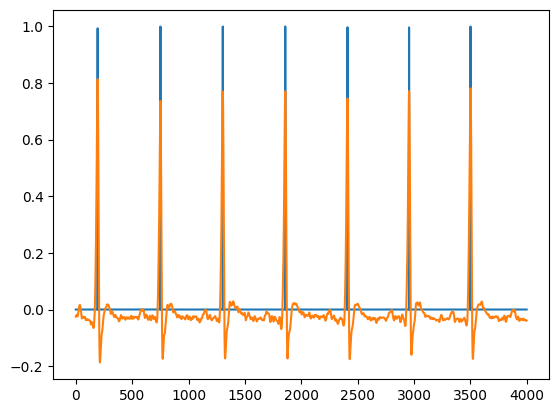

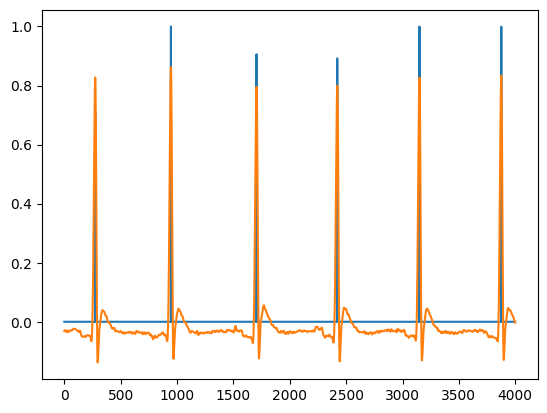

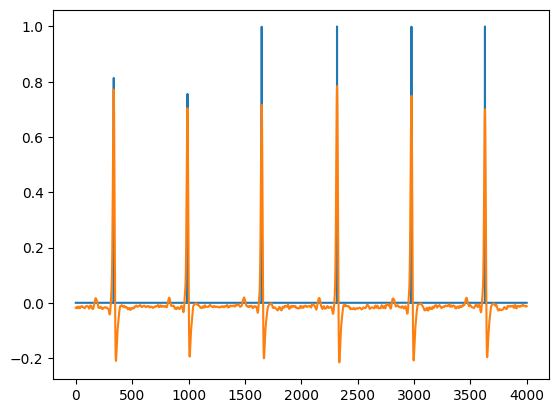

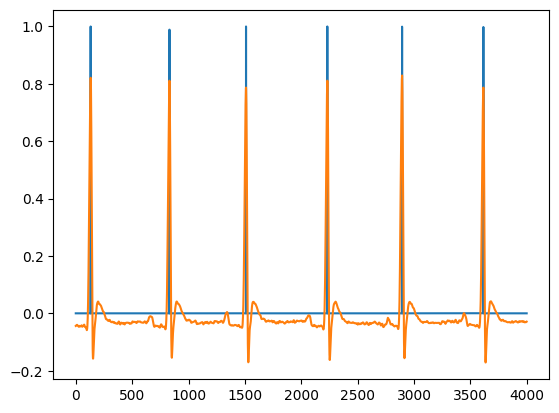

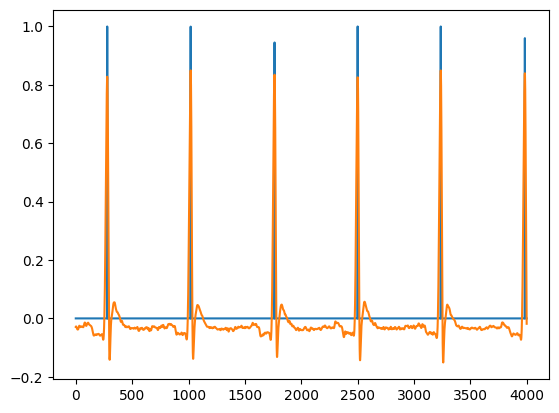

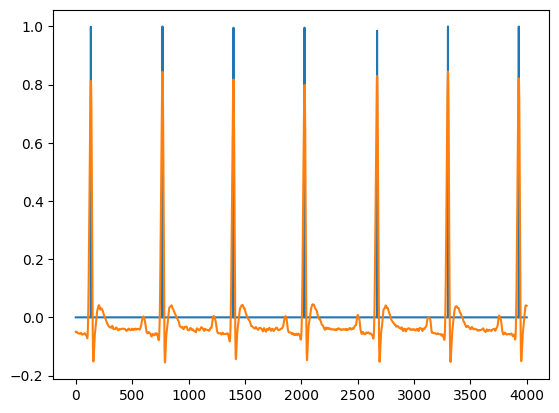

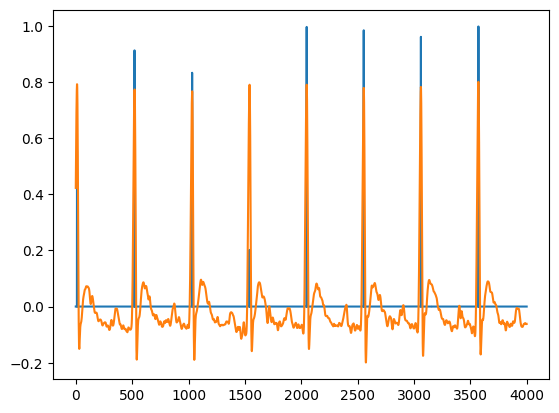

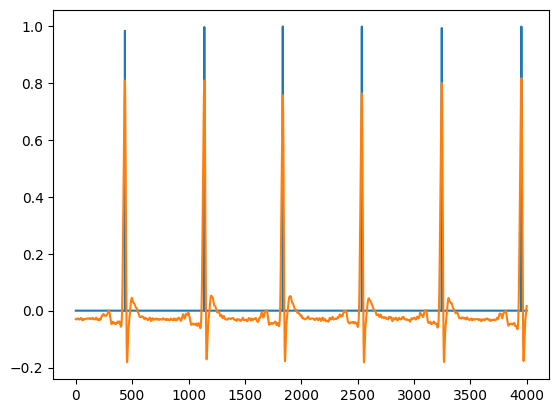

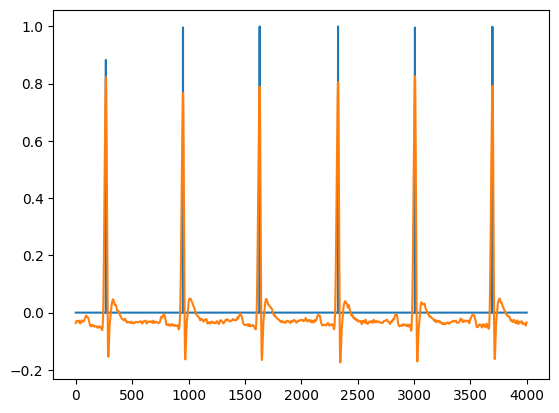

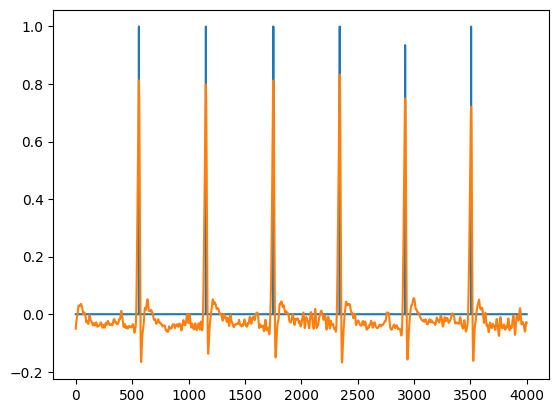

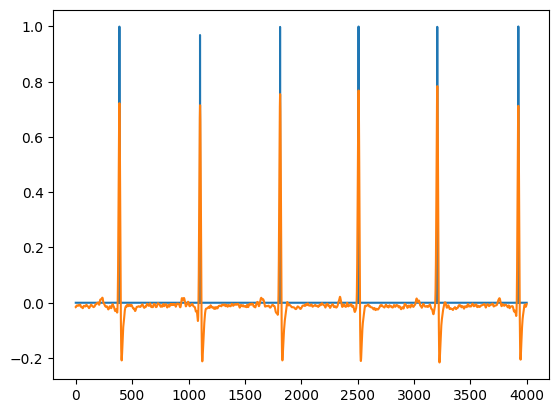

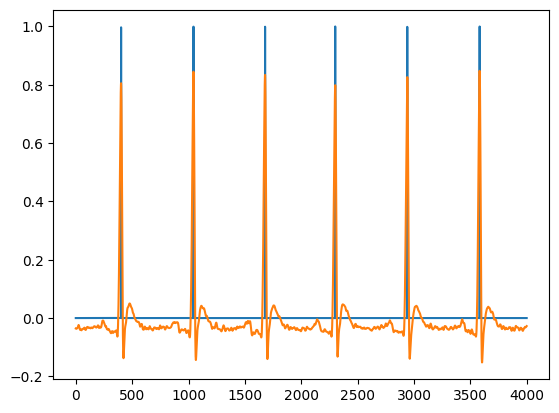

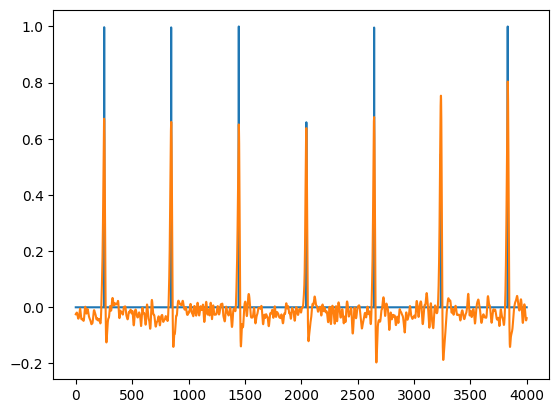

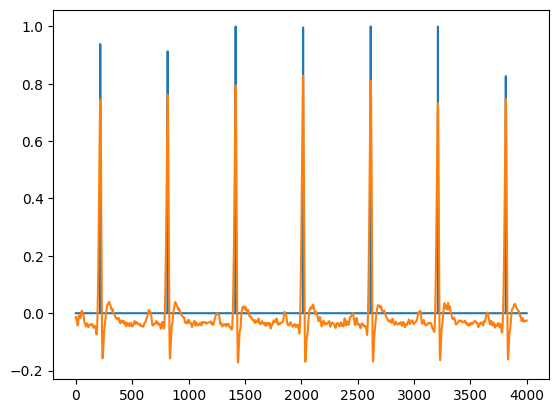

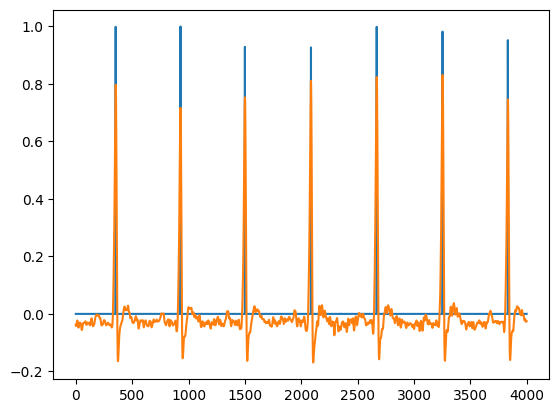

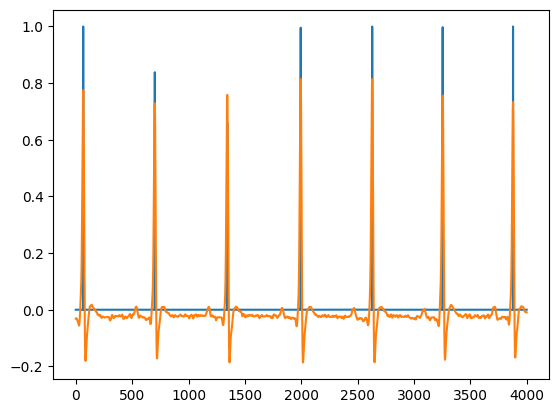

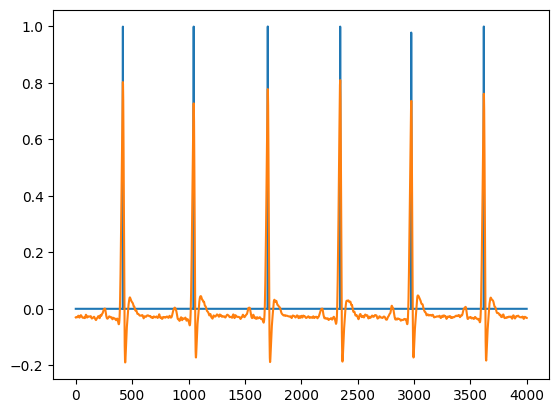

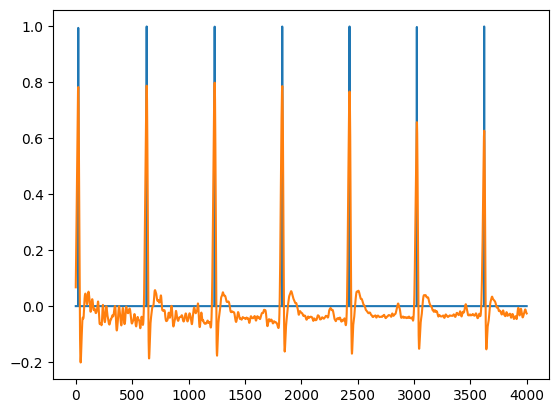

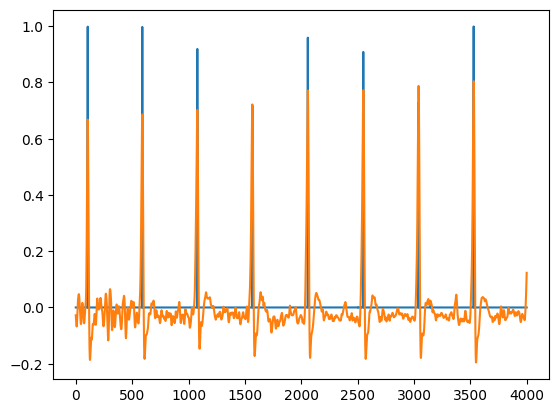

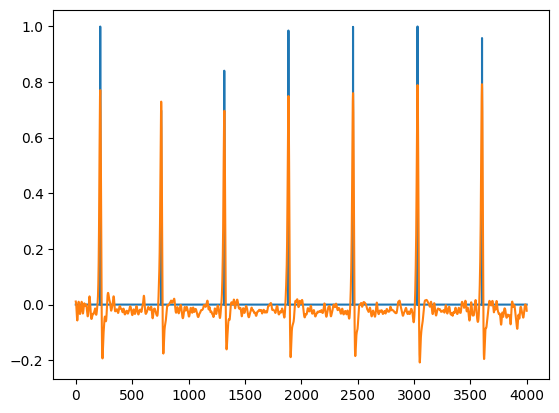

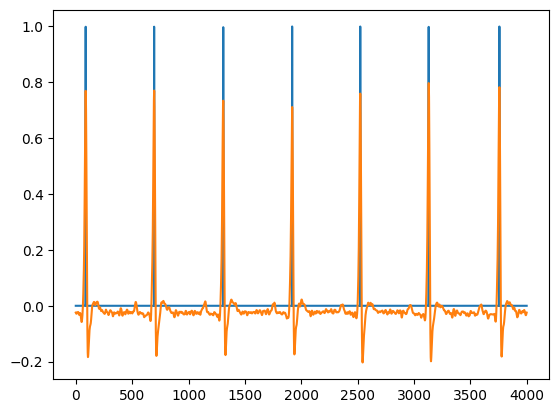

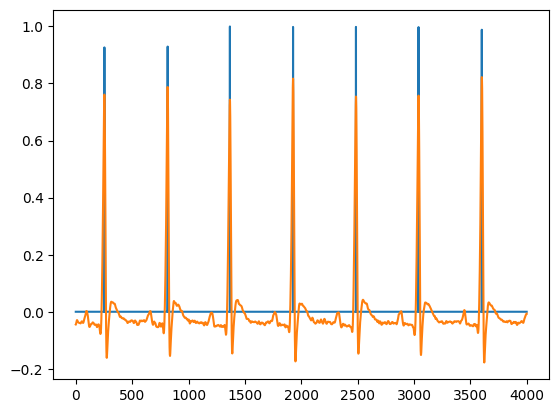

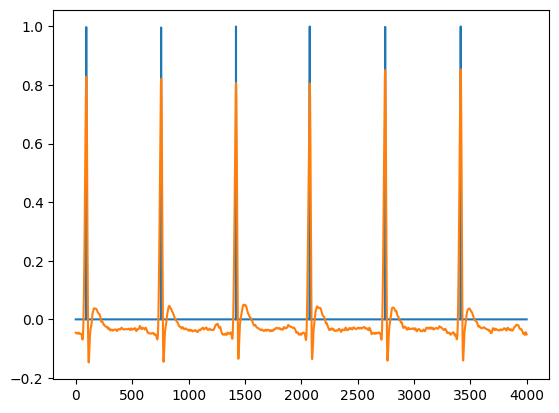

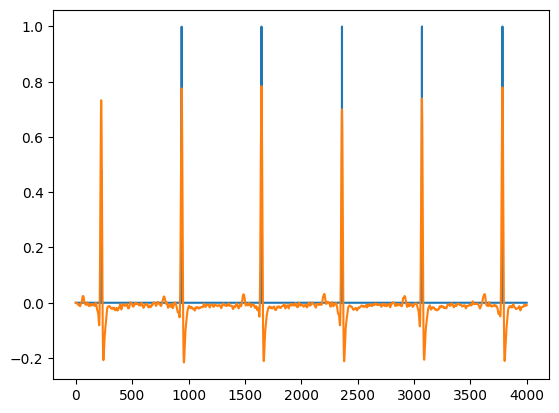

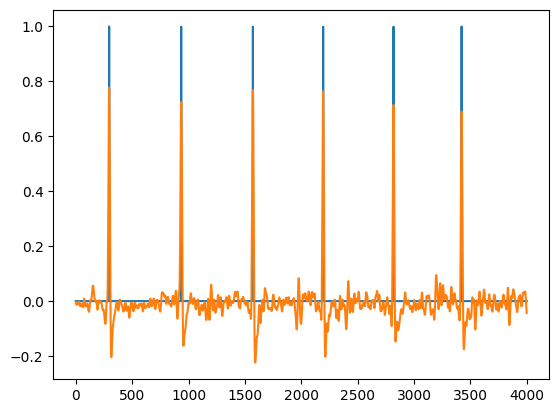

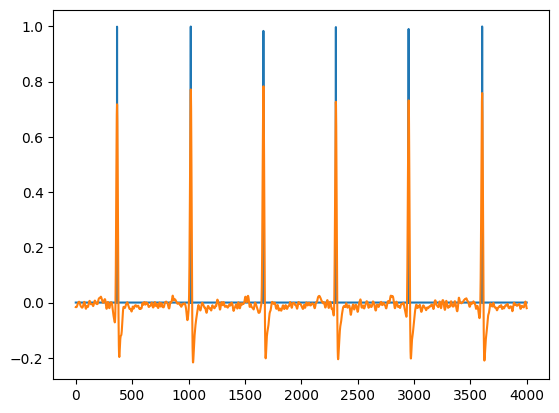

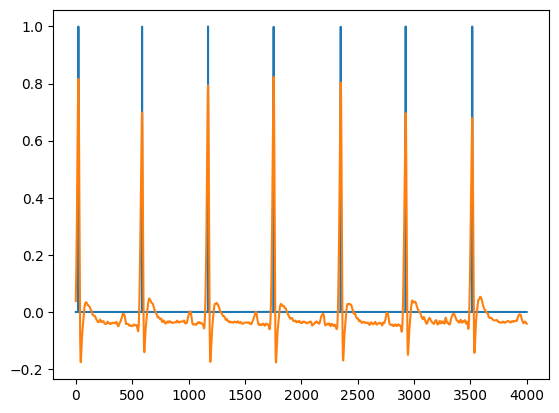

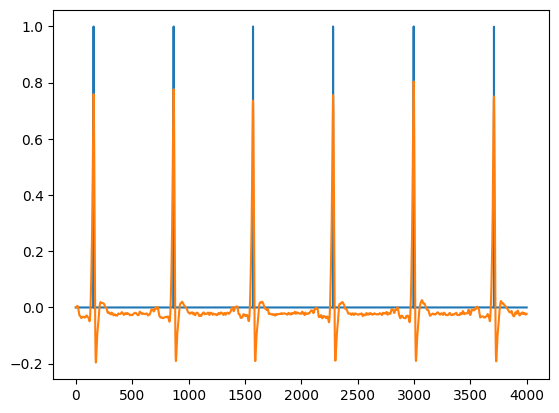

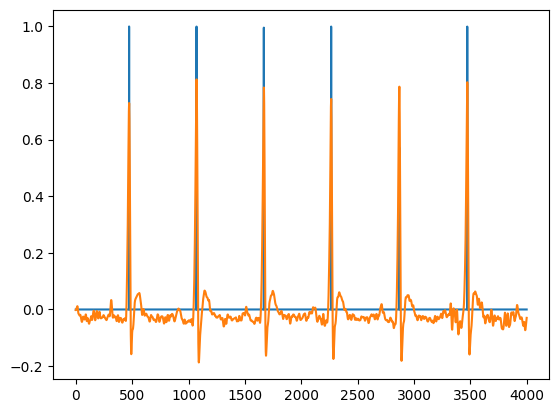

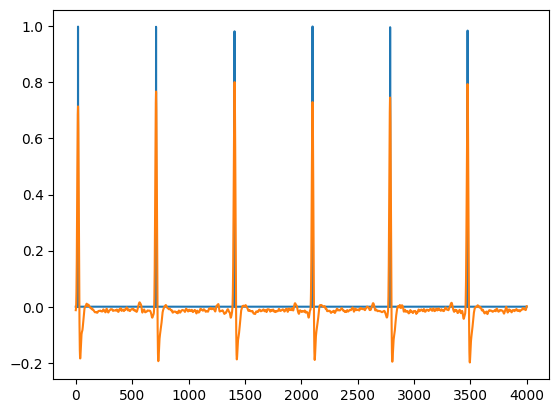

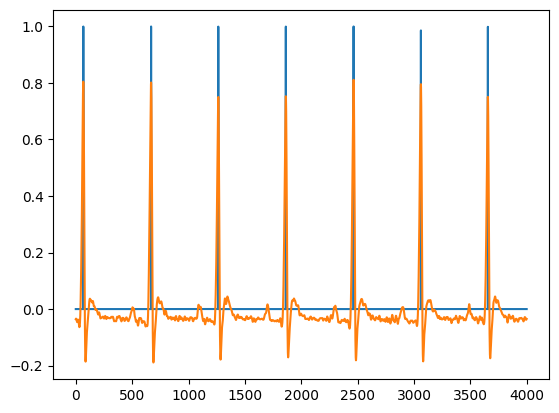

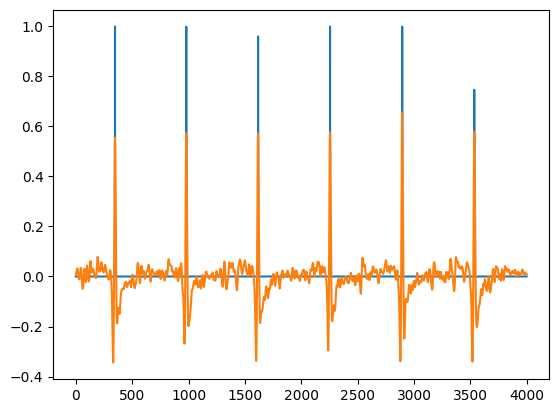

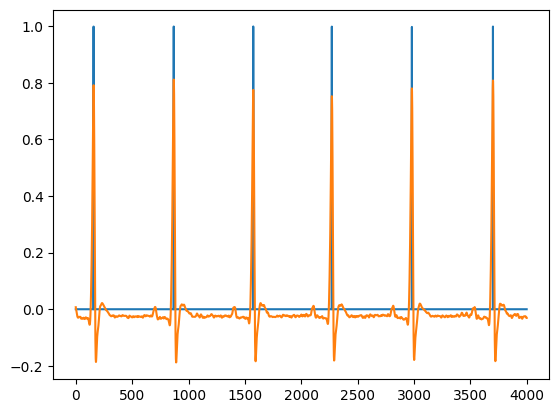

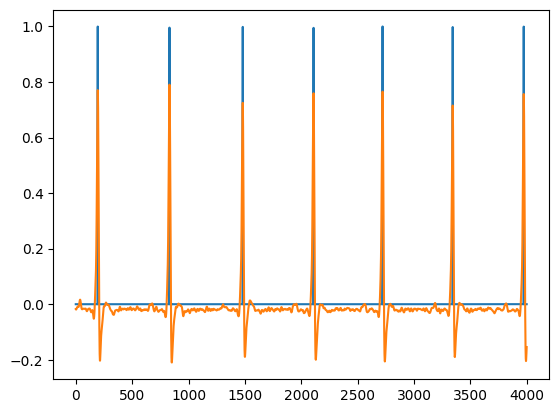

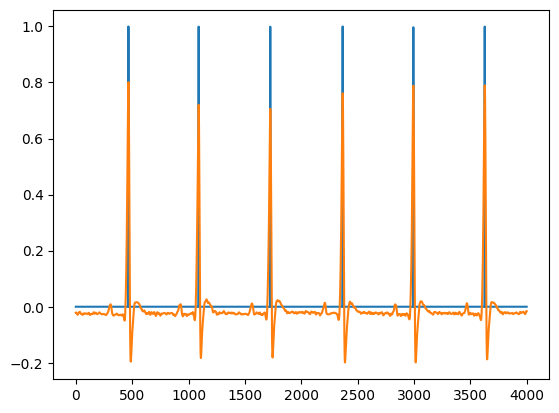

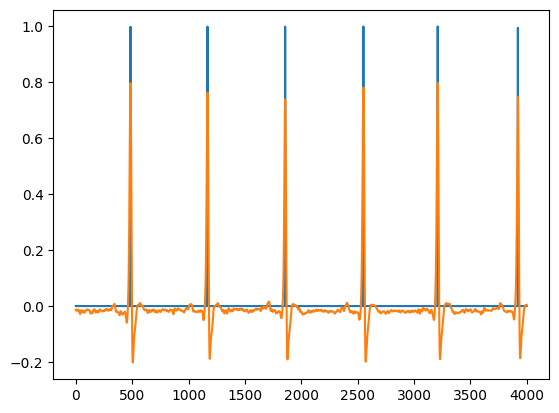

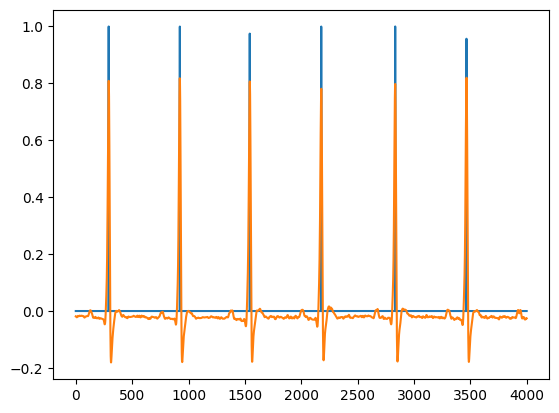

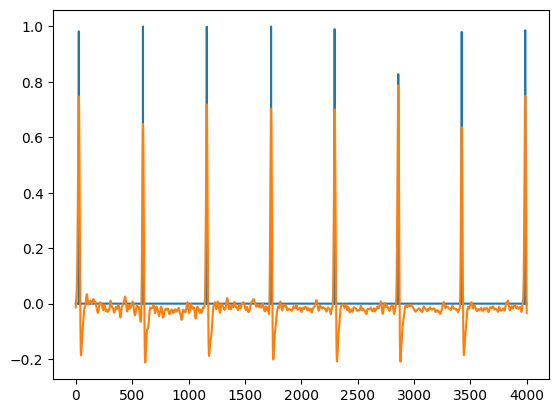

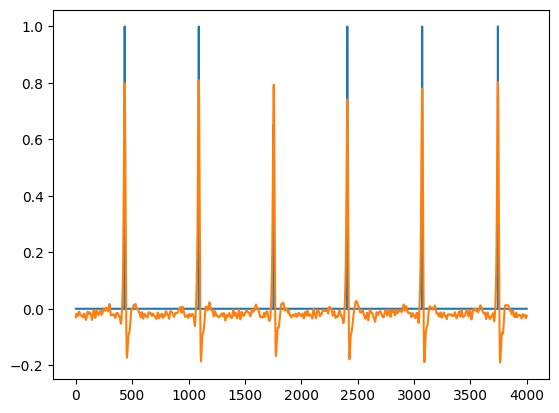

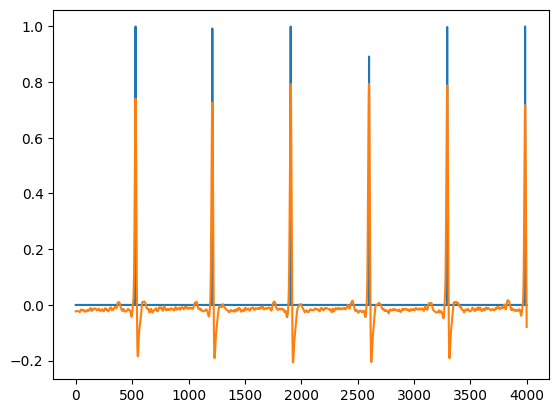

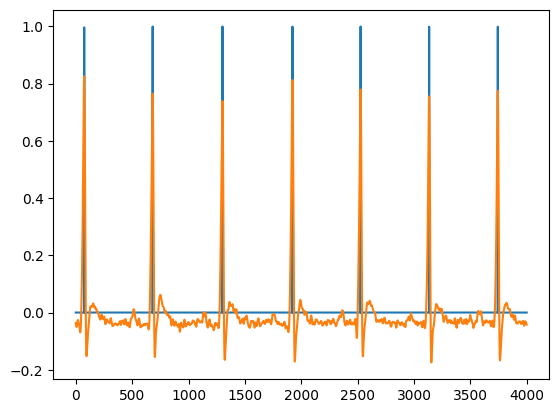

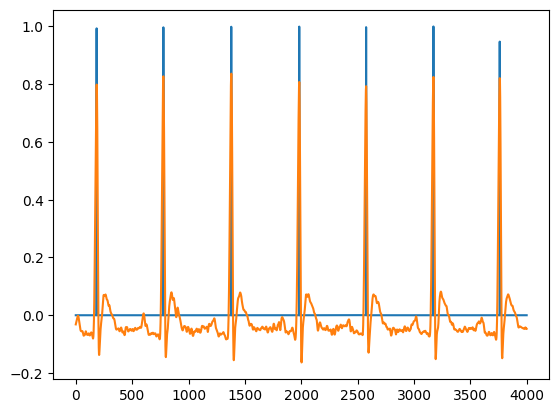

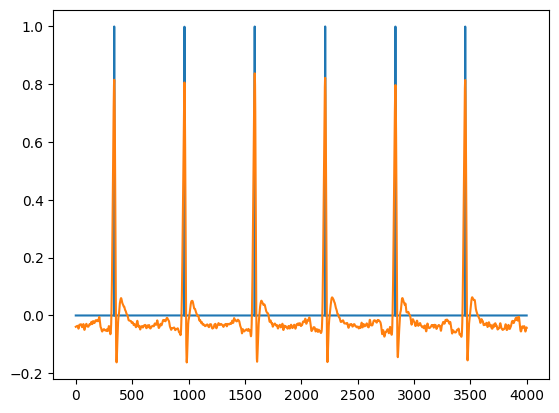

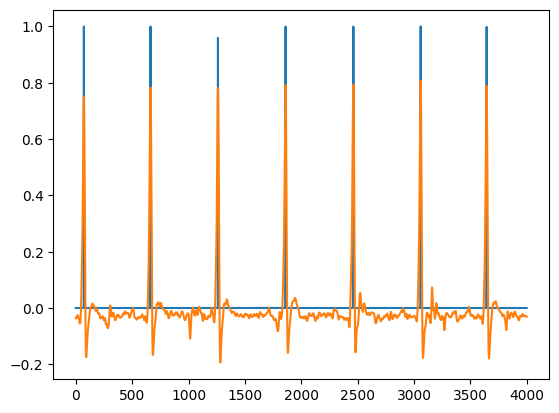

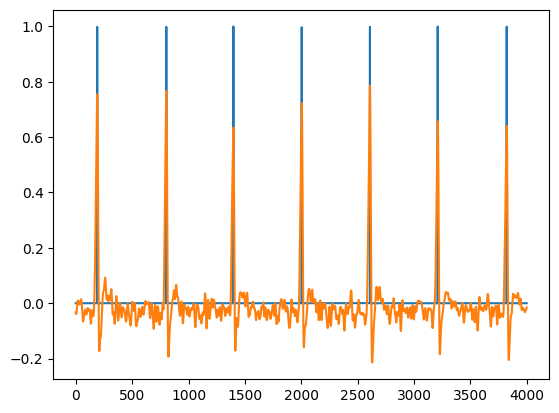

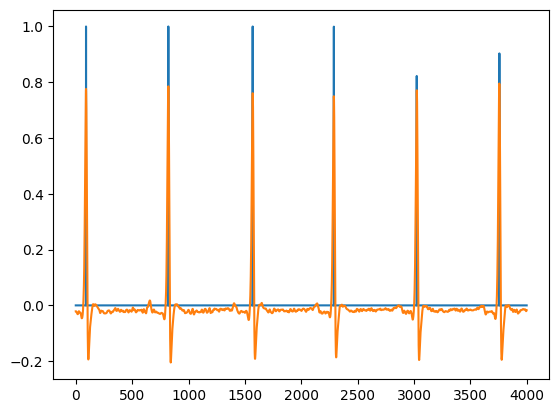

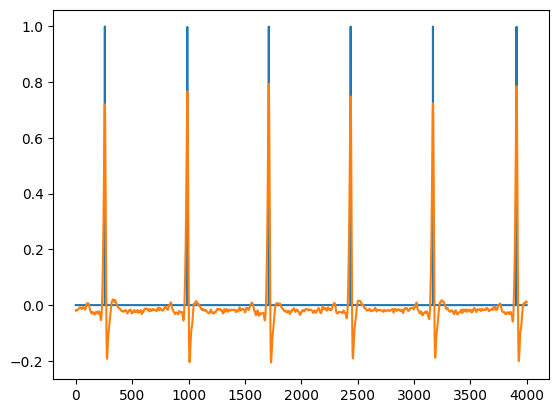

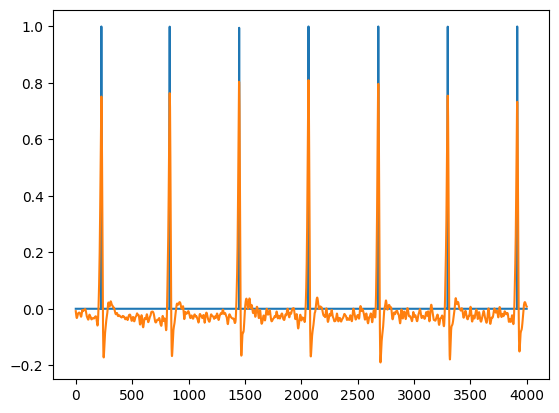

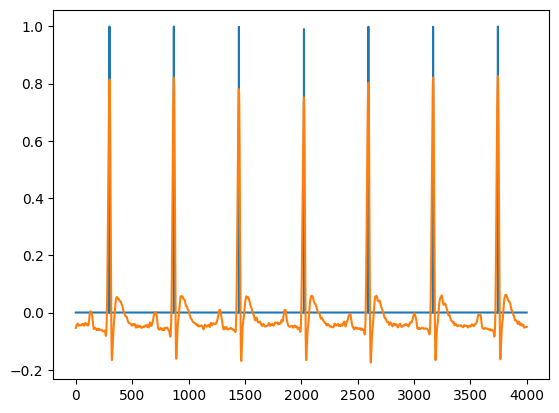

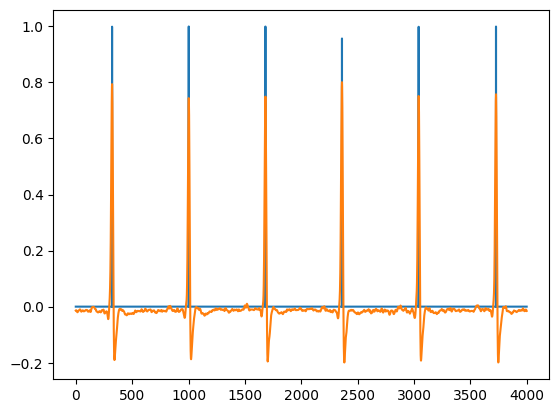

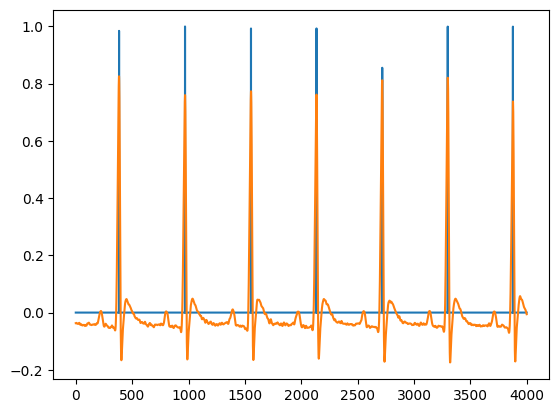

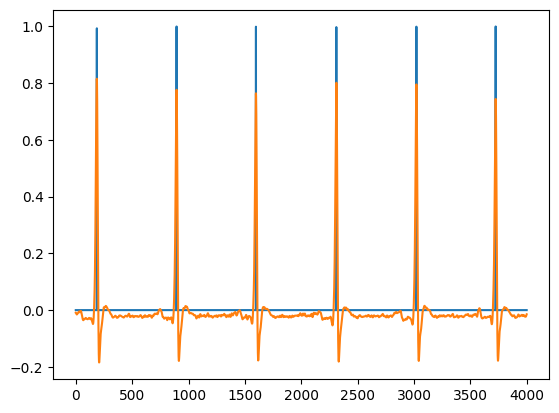

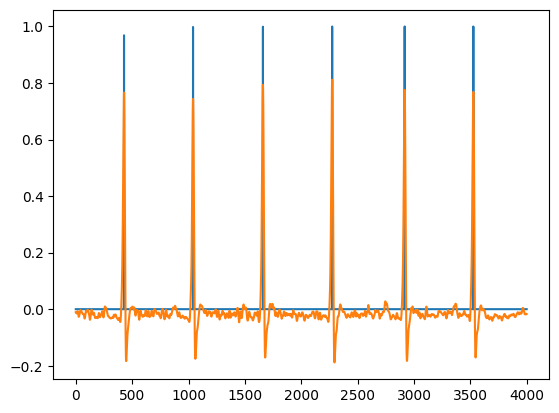

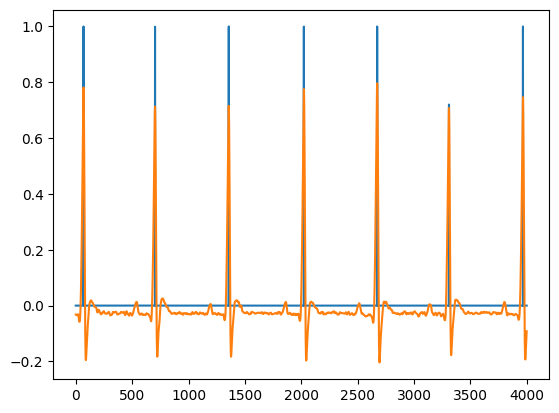

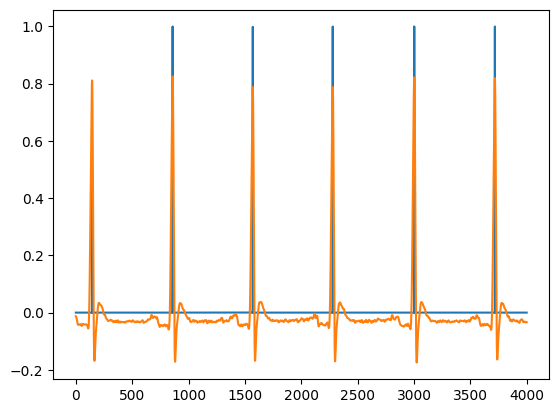

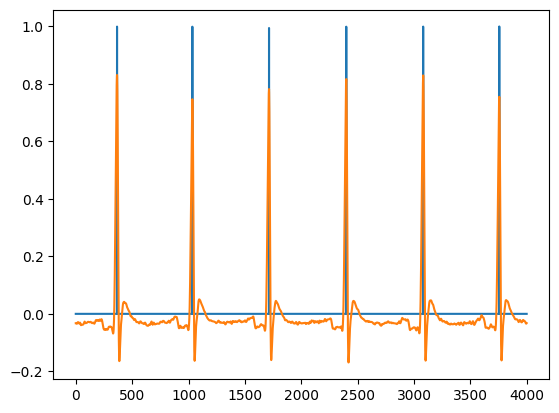

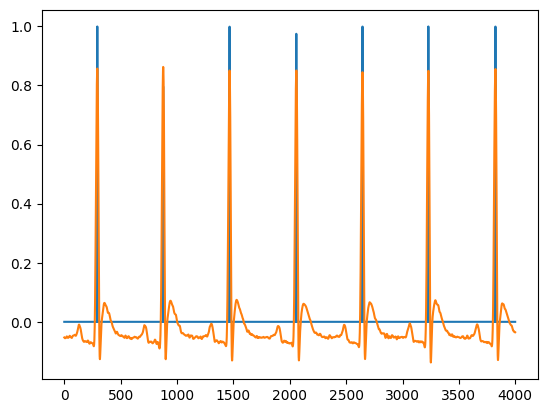

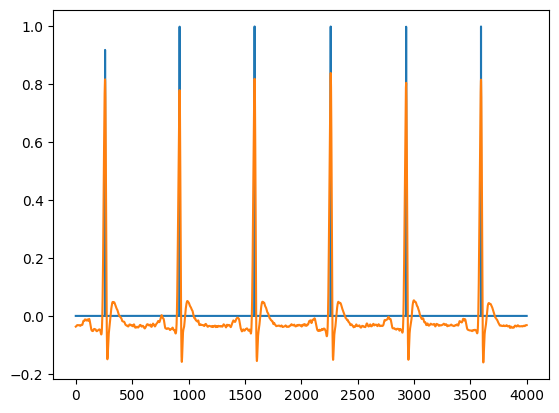

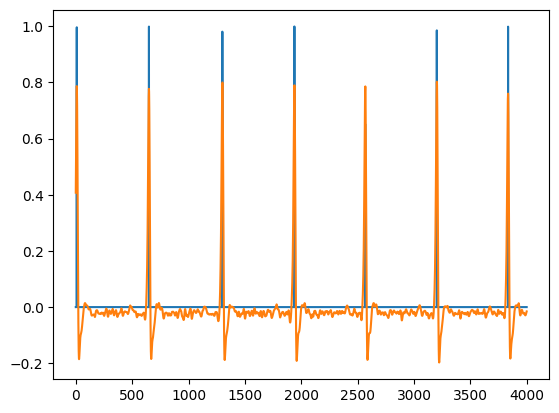

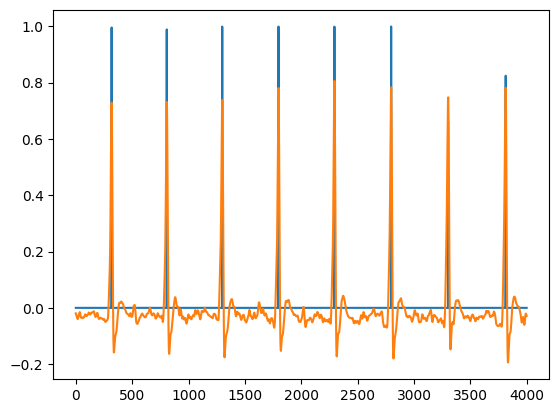

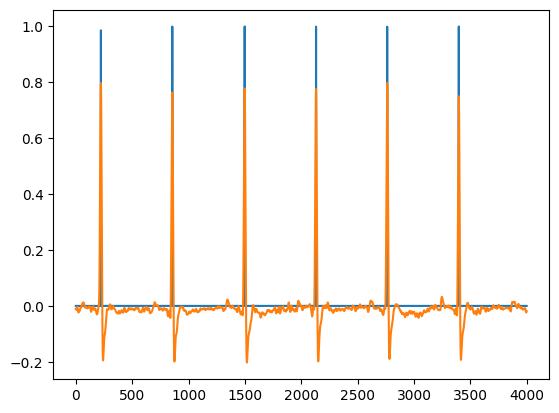

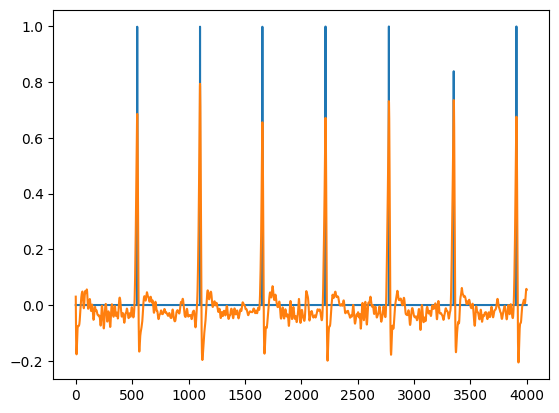

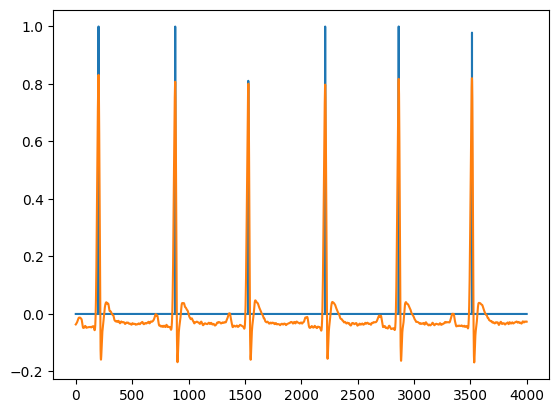

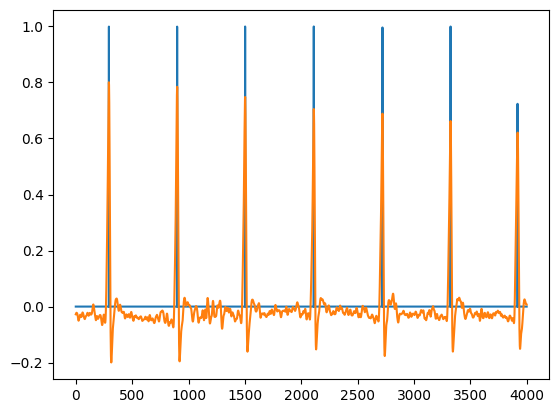

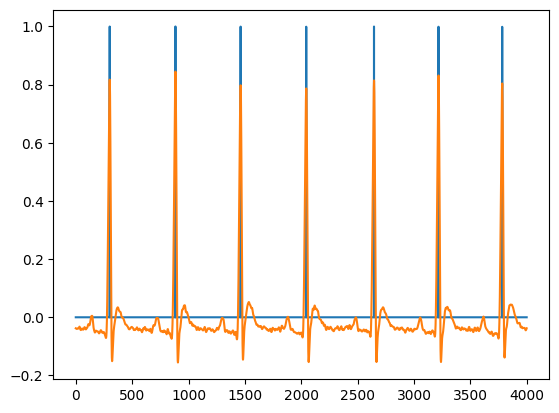

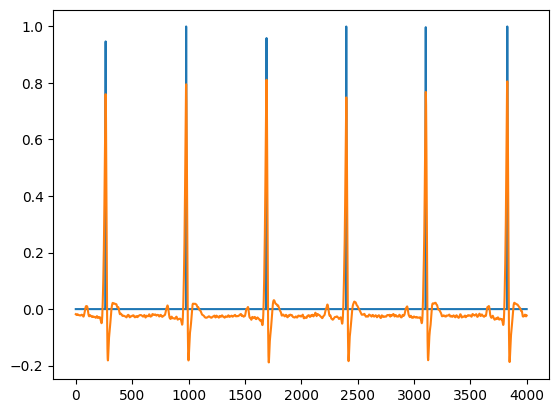

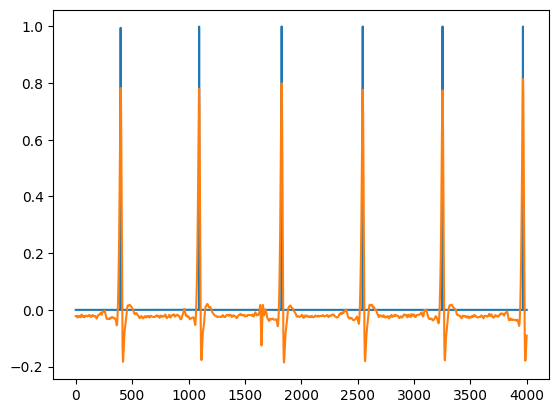

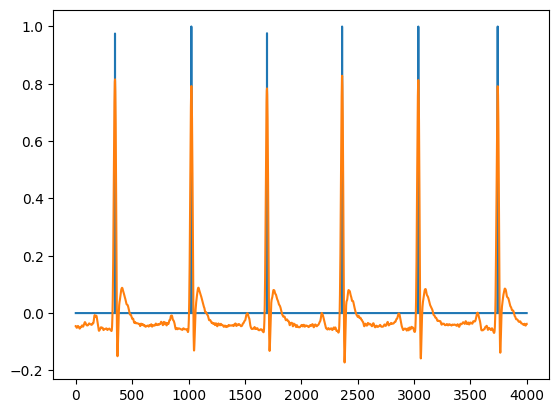

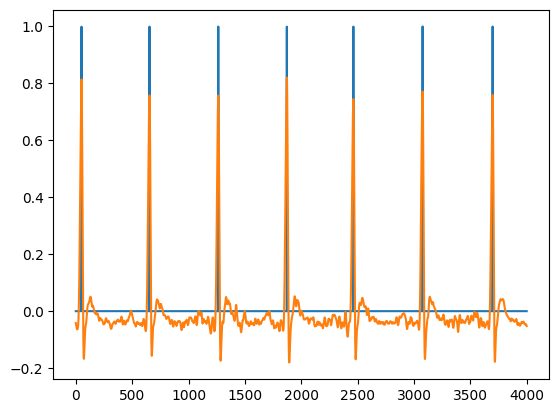

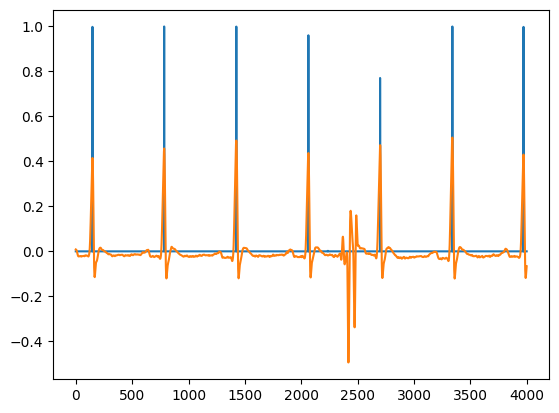

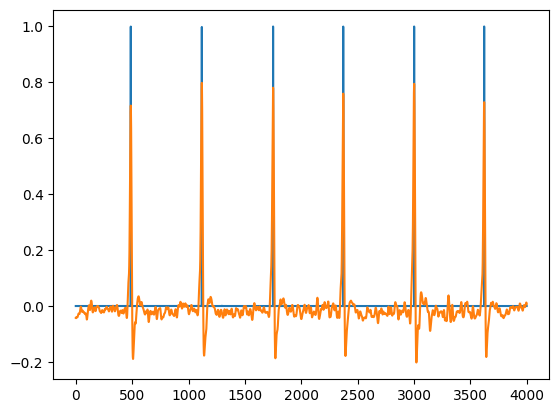

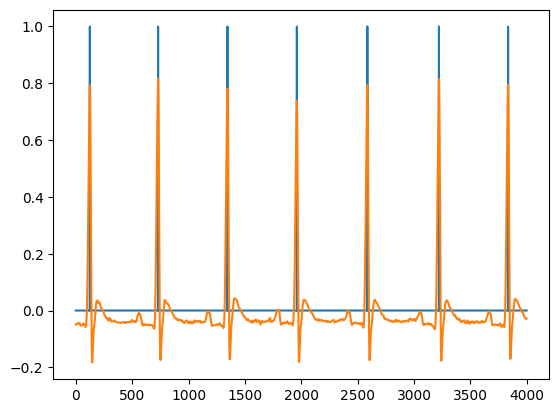

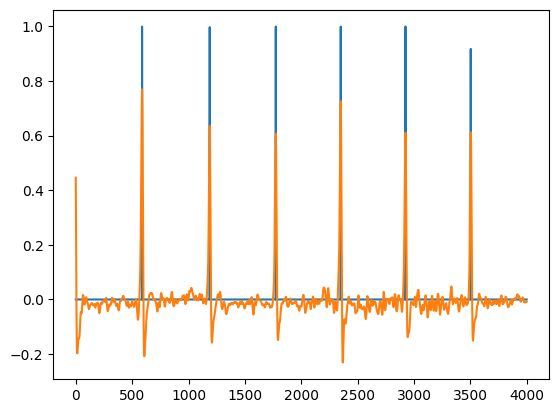

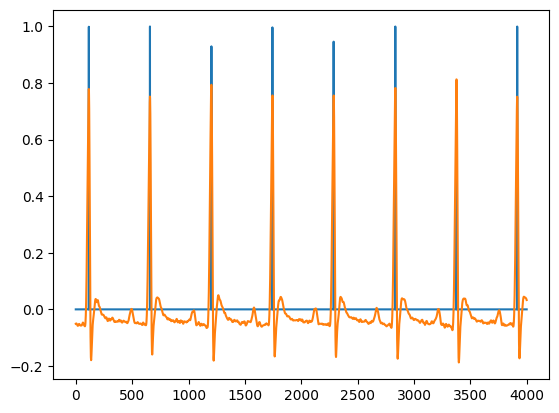

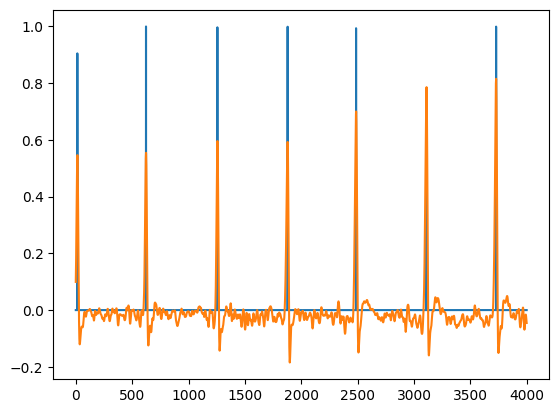

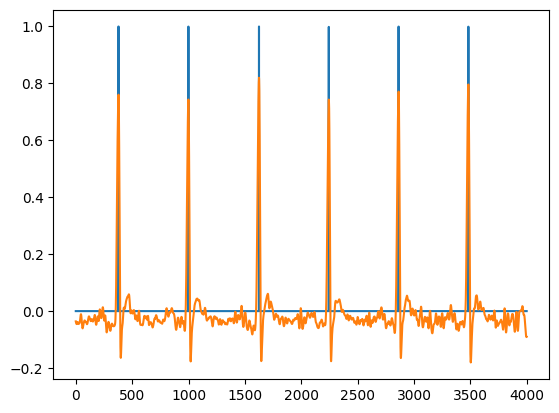

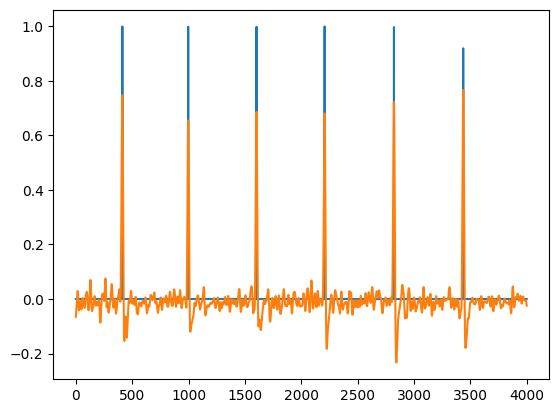

In [20]:
for i in range(len(y_pred)):
    plt.plot(scipy.special.expit(y_pred[i]))
    # plt.plot(y_sample[0])
    plt.plot(x_sample[i, :, 0])
    plt.show()